<h1>CREATION D'ALGORITHMES POUR DETECTION DE FAUX BILLETS EN EUROS</h1>

<h2><i>Contexte :</i></h2>

<p>Dans le cadre de la lutte contre le faux-monnayage, ce notebook est créé pour pouvoir mettre en place une modélisation qui serait capable d’identifier automatiquement les vrais des faux billets en euros. Et ce à partir simplement de certaines dimensions du billet et des éléments qui le composent.</p>

<h2><i>Etape 1 : Importation des bibliothèques Python</i></h2>

In [197]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import t, shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from scipy.cluster.hierarchy import dendrogram, linkage

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import seaborn as sns

<p>Pour les graphiques et options, on 'charge' seaborn :</p>

In [198]:
sns.set()

<h2><i>Etape 2 : Importation, exploration et vérification de données</i></h2>

In [199]:
# Importer et afficher le fichier "billets.csv"
billets_prod = pd.read_csv("billets.csv", decimal=".", index_col=0, delimiter=';')
billets_prod.head()

diagonal  height_left  height_right  margin_low  margin_up  length
is_genuine                                                                    
True          171.81       104.86        104.95        4.52       2.89  112.83
True          171.46       103.36        103.66        3.77       2.99  113.09
True          172.69       104.48        103.50        4.40       2.94  113.16
True          171.36       103.91        103.94        3.62       3.01  113.51
True          171.73       104.28        103.46        4.04       3.48  112.54

In [200]:
# Vérifier le types de chaque variable
billets_prod.dtypes

diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [201]:
# Afficher le nombre de lignes et colonnes
billets_prod.shape

(1500, 6)

In [202]:
# Visualiser les informations relatives aux données
billets_prod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1500 entries, True to False
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1500 non-null   float64
 1   height_left   1500 non-null   float64
 2   height_right  1500 non-null   float64
 3   margin_low    1463 non-null   float64
 4   margin_up     1500 non-null   float64
 5   length        1500 non-null   float64
dtypes: float64(6)
memory usage: 82.0+ KB


In [203]:
# Visualiser les valeurs manquantes
billets_prod.isna().mean()

diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      0.024667
margin_up       0.000000
length          0.000000
dtype: float64

In [204]:
# Calculer les statistiques élémentaires
billets_prod.describe()

diagonal  height_left  height_right   margin_low    margin_up  \
count  1500.000000  1500.000000   1500.000000  1463.000000  1500.000000   
mean    171.958440   104.029533    103.920307     4.485967     3.151473   
std       0.305195     0.299462      0.325627     0.663813     0.231813   
min     171.040000   103.140000    102.820000     2.980000     2.270000   
25%     171.750000   103.820000    103.710000     4.015000     2.990000   
50%     171.960000   104.040000    103.920000     4.310000     3.140000   
75%     172.170000   104.230000    104.150000     4.870000     3.310000   
max     173.010000   104.880000    104.950000     6.900000     3.910000   

           length  
count  1500.00000  
mean    112.67850  
std       0.87273  
min     109.49000  
25%     112.03000  
50%     112.96000  
75%     113.34000  
max     114.44000

In [205]:
# Voir s'il y'a des lignes en double
billets_prod.duplicated().sum()

0

<h2><i>Etape 3 : Nettoyage du dataframe "billets_prod"</i></h2>

In [206]:
# Réindexer le Dataframe "billets_prod"
billets_prod = billets_prod.reset_index()
billets_prod.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0        True    171.81       104.86        104.95        4.52       2.89   
1        True    171.46       103.36        103.66        3.77       2.99   
2        True    172.69       104.48        103.50        4.40       2.94   
3        True    171.36       103.91        103.94        3.62       3.01   
4        True    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [207]:
# Remplacer 'True' par 0 et 'False' par 1 dans la colonne "is_genuine"
billets_prod['is_genuine'] = billets_prod['is_genuine'].replace({True: 0, False: 1})

# Afficher le DataFrame mis à jour
billets_prod.head()

is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
0           0    171.81       104.86        104.95        4.52       2.89   
1           0    171.46       103.36        103.66        3.77       2.99   
2           0    172.69       104.48        103.50        4.40       2.94   
3           0    171.36       103.91        103.94        3.62       3.01   
4           0    171.73       104.28        103.46        4.04       3.48   

   length  
0  112.83  
1  113.09  
2  113.16  
3  113.51  
4  112.54

In [208]:
# Renommer les colonnes
billets_prod = billets_prod.rename(columns={"is_genuine": "est_authentique", "diagonal": "diagonale", "height_left": "hauteur_gauche", "height_right": "hauteur_droite", "margin_low": "marge_inférieure", "margin_up": "marge_extérieure", "length": "longueur"})
billets_prod.head()

est_authentique  diagonale  hauteur_gauche  hauteur_droite  \
0                0     171.81          104.86          104.95   
1                0     171.46          103.36          103.66   
2                0     172.69          104.48          103.50   
3                0     171.36          103.91          103.94   
4                0     171.73          104.28          103.46   

   marge_inférieure  marge_extérieure  longueur  
0              4.52              2.89    112.83  
1              3.77              2.99    113.09  
2              4.40              2.94    113.16  
3              3.62              3.01    113.51  
4              4.04              3.48    112.54

In [209]:
# Arrondir les valeurs de chaque colonne à deux chiffres après la virgule
billets_prod = billets_prod.round(2)

<h2><i>Etape 4 : Analyse descriptive des données et prédiction des valeurs manquantes</i></h2>

<h3><i>1- Statistiques descriptives pour les différentes dimensions :</i></h3>

In [210]:
# Liste des colonnes pour lesquelles nous souhaitons calculer les statistiques
columns =  ["diagonale", "hauteur_gauche", "hauteur_droite","marge_inférieure", "marge_extérieure", "longueur"]

# Initialiser une liste vide pour stocker les résultats
summary_stats = []

for col in columns:
    dimension = col.replace("_", " ").title()  # Formatage du nom de la dimension
    mean_value = billets_prod[col].mean()
    median_value = billets_prod[col].median()
    std_deviation = billets_prod[col].std()
    min_value = billets_prod[col].min()
    max_value = billets_prod[col].max()

    # Créer un dictionnaire pour stocker les statistiques de cette dimension
    dimension_stats = {
        "Dimension": dimension,
        "Moyenne": mean_value,
        "Médiane": median_value,
        "Écart_type": std_deviation,
        "Min": min_value,
        "Max": max_value
    }

    # Ajouter les statistiques à la liste
    summary_stats.append(dimension_stats)

# Créer un DataFrame à partir de la liste de statistiques
summary_stats_df = pd.DataFrame(summary_stats)

# Afficher le DataFrame
print(summary_stats_df)

          Dimension     Moyenne  Médiane  Écart_type     Min     Max
0         Diagonale  171.958440   171.96    0.305195  171.04  173.01
1    Hauteur Gauche  104.029533   104.04    0.299462  103.14  104.88
2    Hauteur Droite  103.920307   103.92    0.325627  102.82  104.95
3  Marge Inférieure    4.485967     4.31    0.663813    2.98    6.90
4  Marge Extérieure    3.151473     3.14    0.231813    2.27    3.91
5          Longueur  112.678500   112.96    0.872730  109.49  114.44


<h3><i>2- Distribution générale des dimensions :</i></h3>

In [211]:
# Supprimer la colonne "est_authentique" du DataFrame
df_1 = billets_prod.drop("est_authentique", axis=1)

<Figure size 800x600 with 0 Axes>

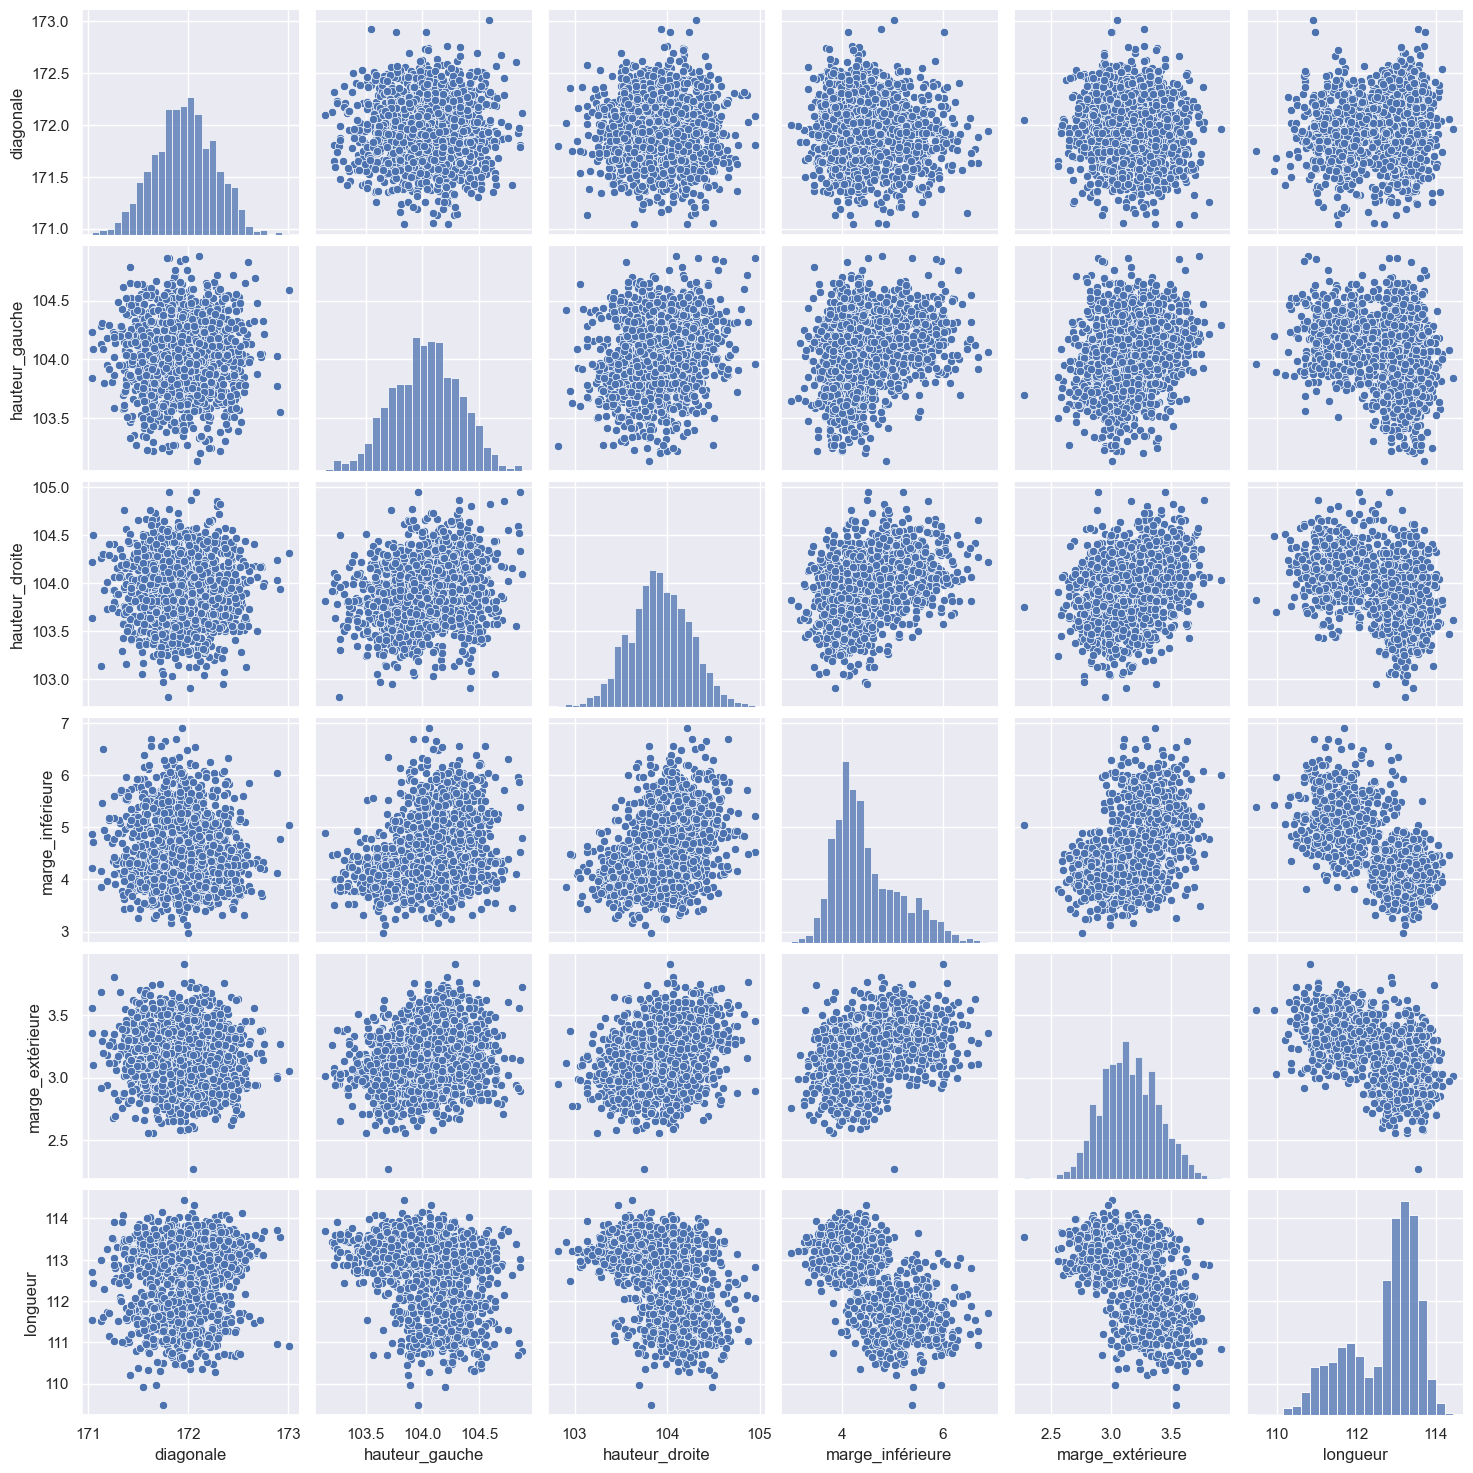

In [212]:
# Créer la pairplot avec le DataFrame modifié
plt.figure(figsize=(8, 6))
sns.pairplot(data=df_1)

# Afficher le graphique
plt.show()

Le pairplot de seaborn nous permet de visualiser la distribution des variables ainsi que des éventuelles corrélations entre elles lorsqu'elles sont prises deux à deux.

Ici, nous pouvons constater, visuellement, qu'il n'existe pas de liens remarquables entre les variables (pas de motifs linéaires, pas de concentrations de points, et pas de direction claire dans les nuages de points).

On peut créer uniquement les histogrammes pour voir la distribution générale de chaque dimension :

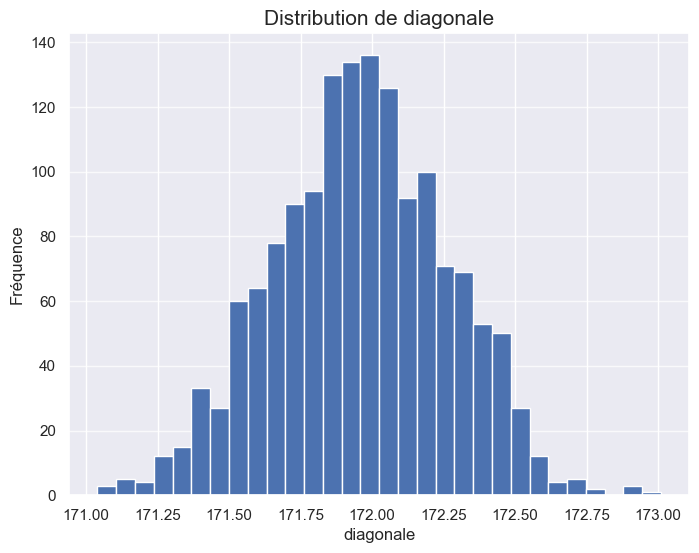

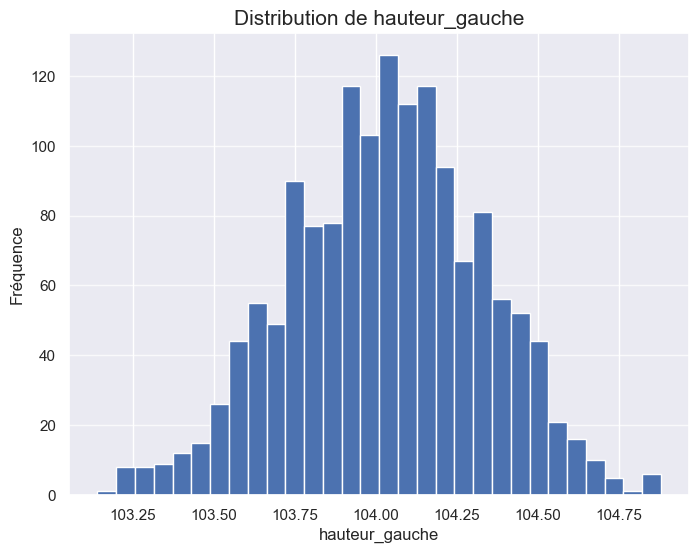

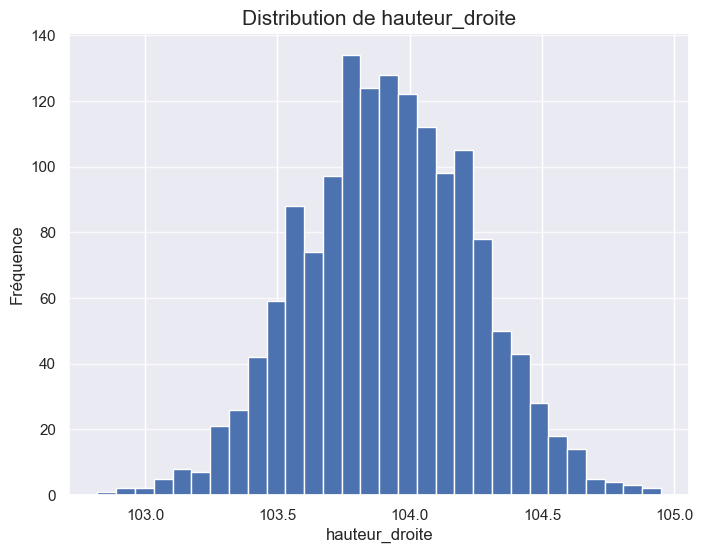

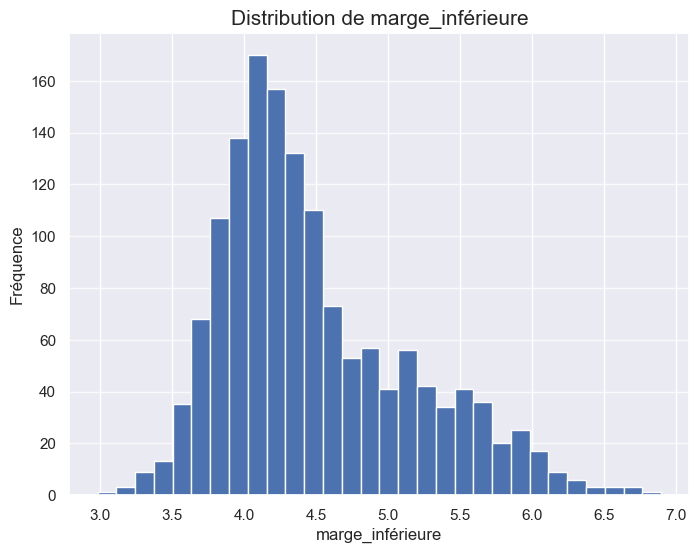

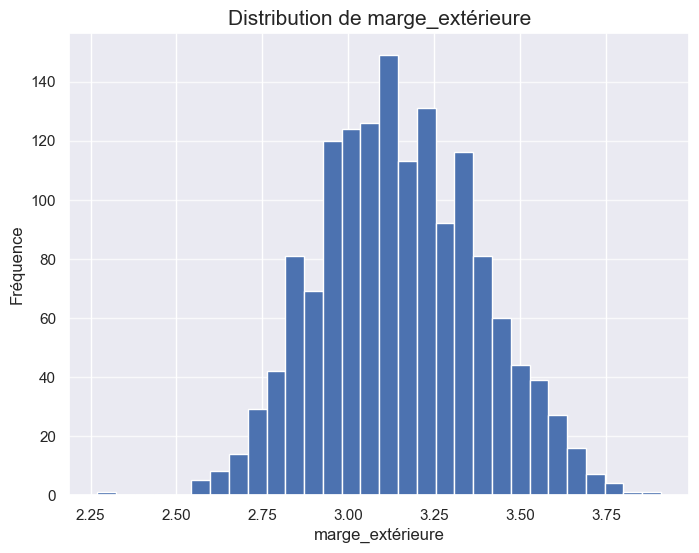

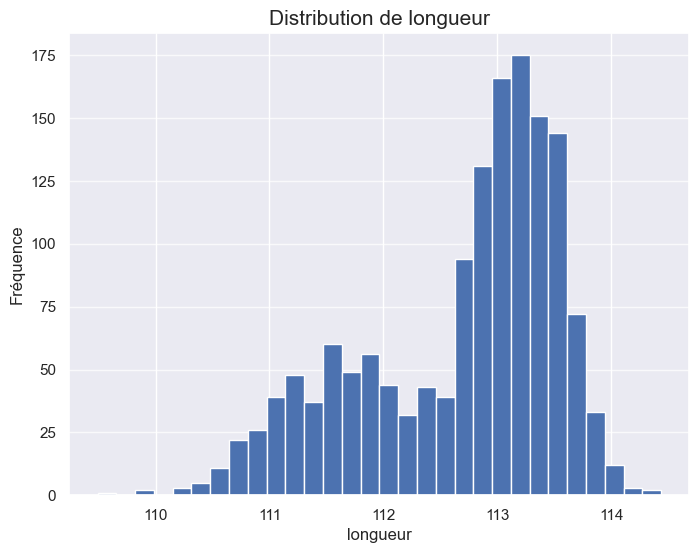

In [213]:
def histo_var(billets_prod): 
    variables = billets_prod.columns[1:]

    for x in variables: 
        plt.figure(figsize=(8, 6))
        billets_prod[x].hist(bins=30)  # Nous pouvons ajuster le nombre de bacs (bins) selon nos préférences
        plt.title(f'Distribution de {x}', fontsize=15)
        plt.xlabel(x, fontsize=12)
        plt.ylabel("Fréquence", fontsize=12)
        plt.grid(axis='y', alpha=0.75)
        plt.show()

# Appeler la fonction avec votre dataframe
histo_var(billets_prod)

<h3><i>3- Distribution générale des dimensions selon l'authenticité des billets :</i></h3>

On peut représenter le nombre de vrais et de faux billets globaux à partir d'un graphique à barres :

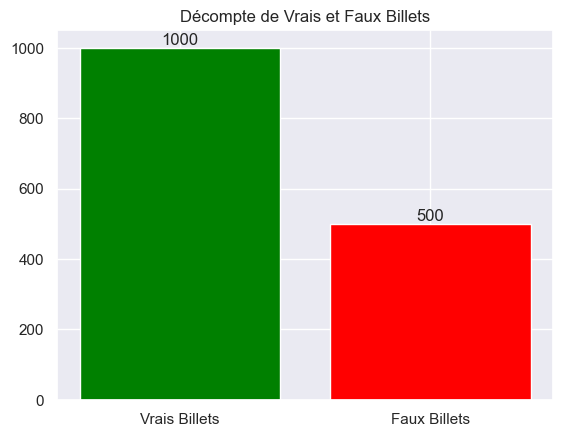

In [214]:
# Compter le nombre de vrais et de faux billets
vrais_count = len(billets_prod[billets_prod["est_authentique"] == 0])
faux_count = len(billets_prod[billets_prod["est_authentique"] == 1])

# Créer une liste de labels pour les catégories
categories = ["Vrais Billets", "Faux Billets"]

# Créer une liste des décomptes correspondants
counts = [vrais_count, faux_count]

# Créer un graphique à barres
plt.bar(categories, counts, color=['green', 'red'])

# Ajouter des étiquettes aux barres
for i, count in enumerate(counts):
    plt.text(categories[i], count, str(count), ha='center', va='bottom')

# Ajouter un titre au graphique
plt.title("Décompte de Vrais et Faux Billets")

# Afficher le graphique
plt.show()

On peut calculer également la valeur moyenne de chaque dimension selon le l'authenticité :

In [215]:
# Calculer la moyenne de chaque dimension pour chaque valeur unique dans la colonne "est_authentique"
billet_v_f = billets_prod.pivot_table(index=["est_authentique"], aggfunc='mean')
billet_v_f

diagonale  hauteur_droite  hauteur_gauche   longueur  \
est_authentique                                                         
0                171.98708       103.80865       103.94913  113.20243   
1                171.90116       104.14362       104.19034  111.63064   

                 marge_extérieure  marge_inférieure  
est_authentique                                      
0                         3.05213          4.116097  
1                         3.35016          5.215935

On peut vérifier également si des caractéristiques différencient nos billets selon le fait qu'ils soient vrais ou faux. Pour cela, on peut visualiser les caractéristiques des billets selon qu'ils soient vrais ou faux :

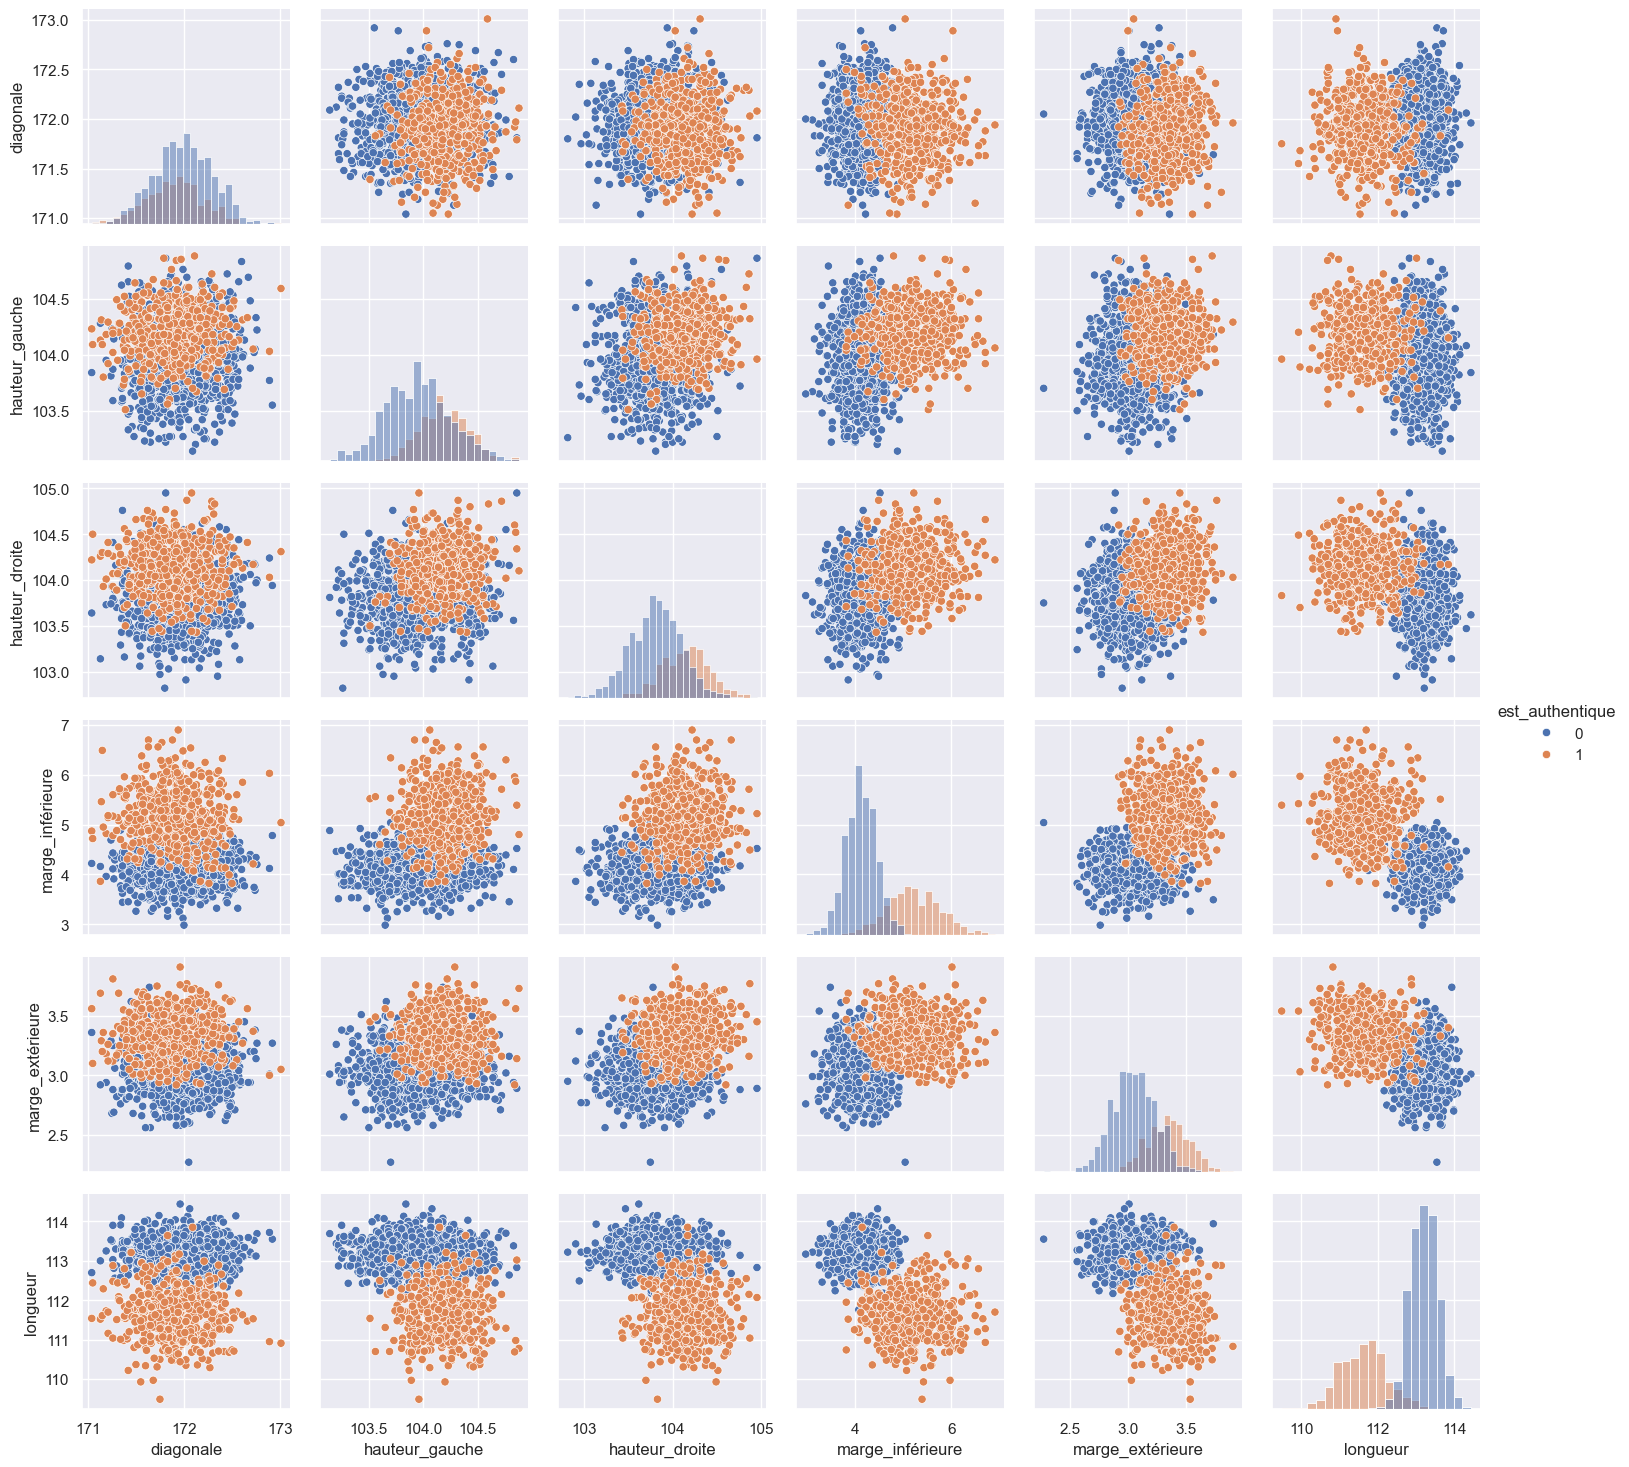

In [216]:
g = sns.PairGrid(billets_prod, hue="est_authentique")
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

On peut se limiter à créer un histogramme pour chaque dimension et distinguer les vrais et les faux billets :

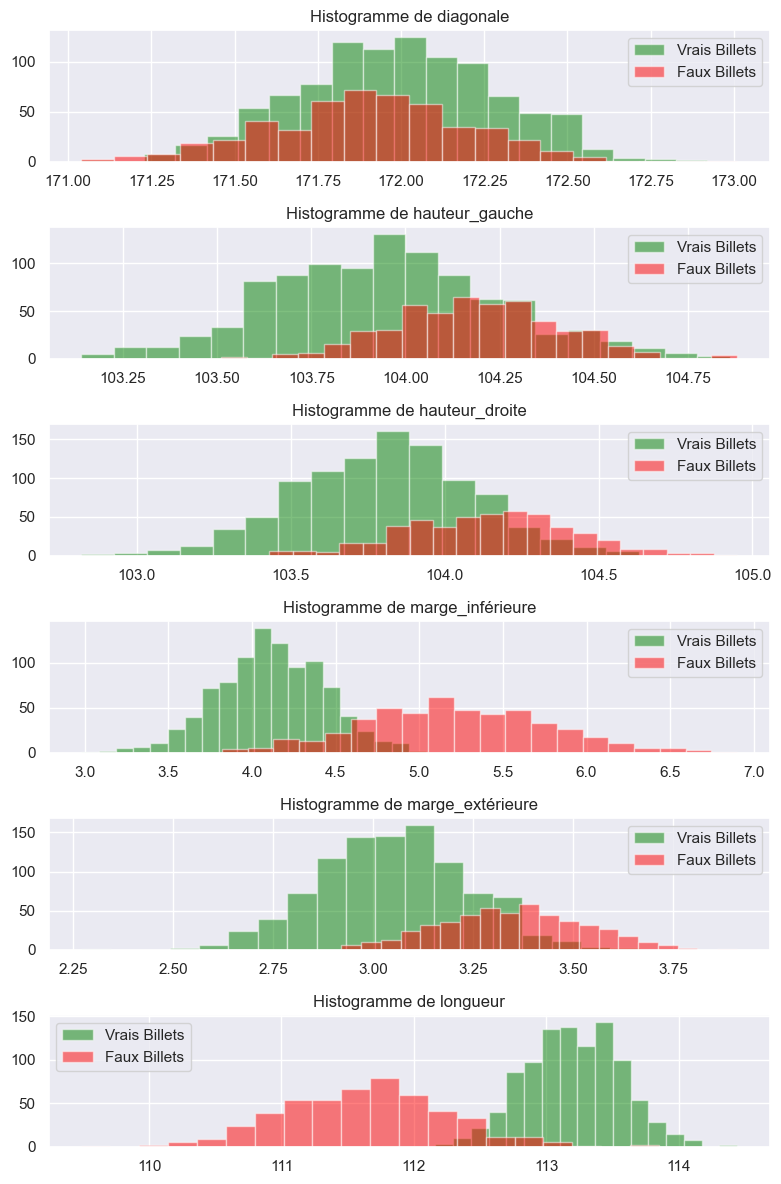

In [217]:
# Séparer le dataframe en deux parties : vrais et faux billets
vrais_billets = billets_prod[billets_prod["est_authentique"] == 0]
faux_billets = billets_prod[billets_prod["est_authentique"] == 1]

# Liste des colonnes pour lesquelles nous souhaitons créer des histogrammes
columns = ["diagonale", "hauteur_gauche", "hauteur_droite", "marge_inférieure", "marge_extérieure", "longueur"]

# Créer un subplot pour chaque dimension
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 12))

for i, col in enumerate(columns):
    # Créer un histogramme pour les vrais billets
    axes[i].hist(vrais_billets[col], bins=20, alpha=0.5, color='green', label='Vrais Billets')

    # Créer un histogramme pour les faux billets
    axes[i].hist(faux_billets[col], bins=20, alpha=0.5, color='red', label='Faux Billets')

    # Ajouter des légendes et un titre à chaque subplot
    axes[i].legend()
    axes[i].set_title(f'Histogramme de {col}')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher les histogrammes
plt.show()

On peut créer aussi des boîtes à moustaches (boxplots) pour chaque dimension en fonction de l'authenticité des billets :

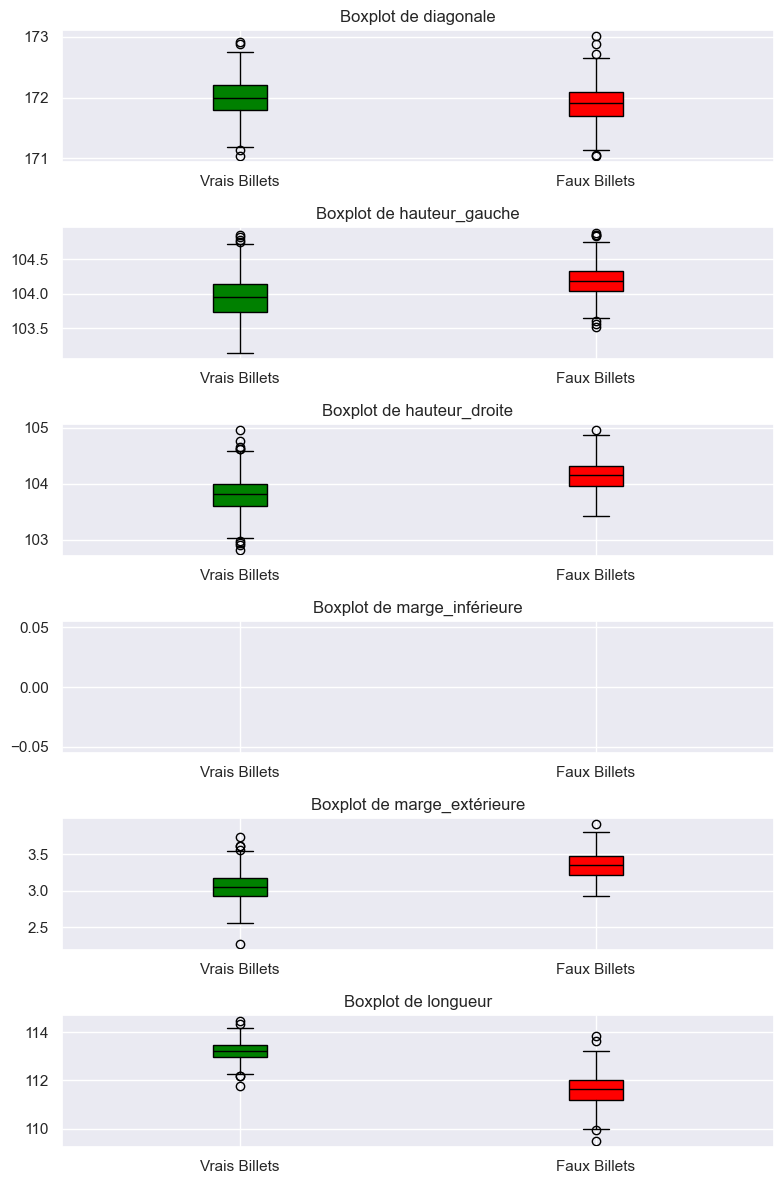

In [218]:
# Créer un subplot pour chaque dimension
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 12))

for i, col in enumerate(columns):
    # Créer un boxplot pour les vrais billets en vert
    axes[i].boxplot([vrais_billets[col]], positions=[1], patch_artist=True, boxprops={'facecolor': 'green'}, medianprops={'color': 'black'}, labels=['Vrais Billets'])

    # Créer un boxplot pour les faux billets en rouge
    axes[i].boxplot([faux_billets[col]], positions=[2], patch_artist=True, boxprops={'facecolor': 'red'}, medianprops={'color': 'black'}, labels=['Faux Billets'])

    # Ajouter des légendes et un titre à chaque subplot
    axes[i].set_title(f'Boxplot de {col}')
    axes[i].set_xticks([1, 2])

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher les boxplots
plt.show()

Nous pouvons de même créer un graphique de densité pour chaque dimension en distinguant les vrais et les faux billets :

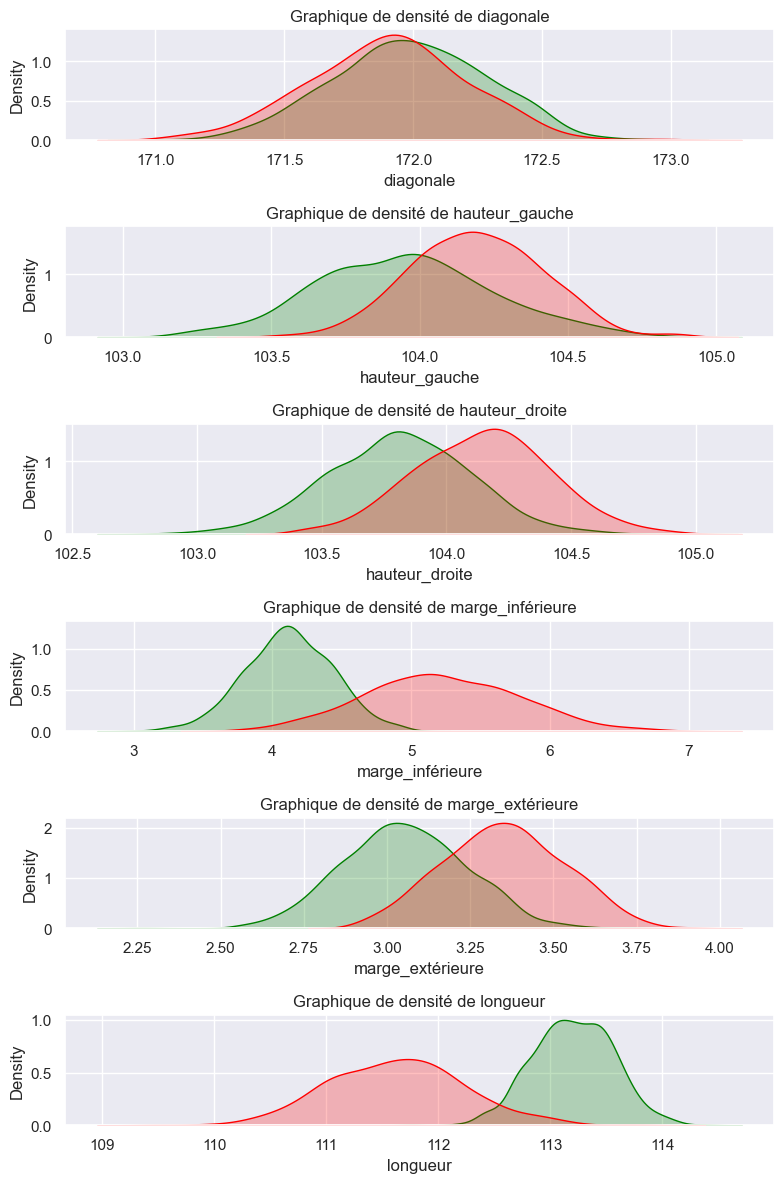

In [219]:
# Créer un subplot pour chaque dimension
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 12))

for i, col in enumerate(columns):
    # Créer un graphique de densité pour les vrais billets en vert
    sns.kdeplot(vrais_billets[col], ax=axes[i], fill=True, label='Vrais Billets', color='green')

    # Créer un graphique de densité pour les faux billets en rouge
    sns.kdeplot(faux_billets[col], ax=axes[i], fill=True, label='Faux Billets', color='red')

    # Ajouter des légendes et un titre à chaque subplot
    axes[i].set_title(f'Graphique de densité de {col}')

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher les graphiques de densité
plt.show()

Et on peut aussi créer des diagrammes de dispersion, pour voir la relation entre deux dimensions différentes :

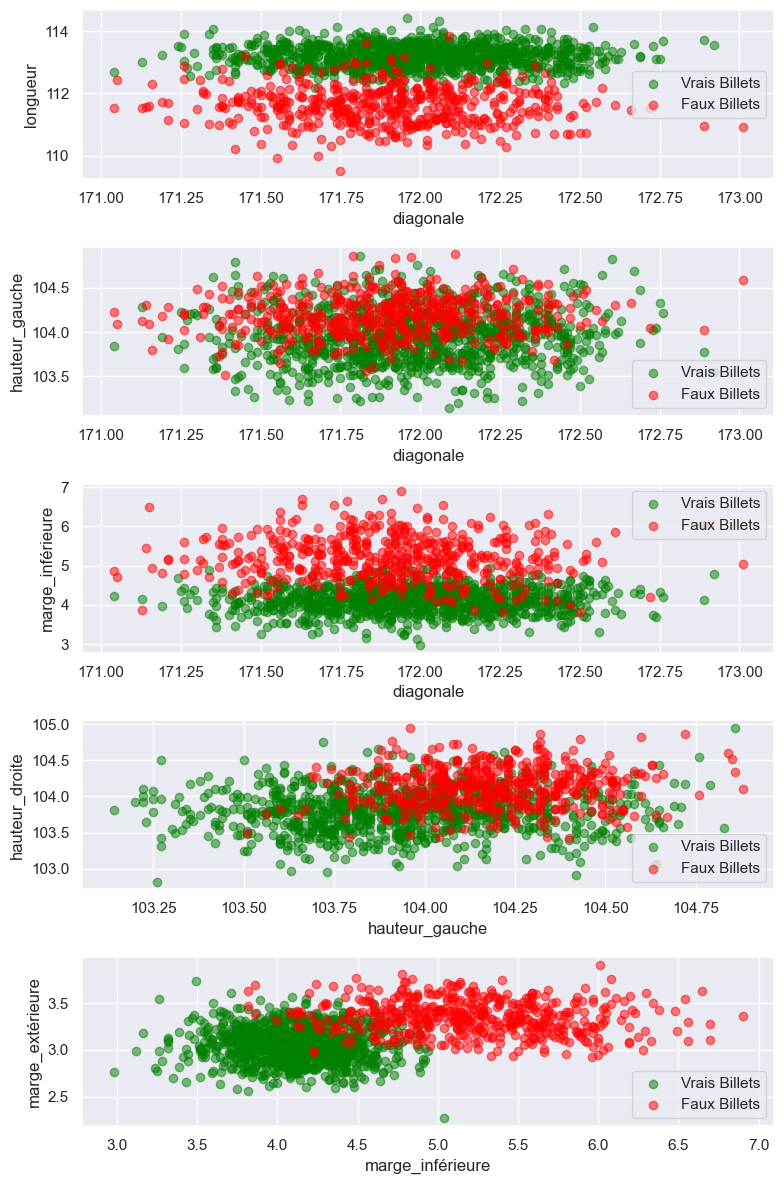

In [220]:
# Liste des paires de colonnes pour lesquelles nous souhaitons créer des diagrammes de dispersion
column_pairs = [("diagonale", "longueur"),("diagonale", "hauteur_gauche"),("diagonale", "marge_inférieure"), ("hauteur_gauche", "hauteur_droite"), ("marge_inférieure", "marge_extérieure")]

# Créer un subplot pour chaque paire de colonnes
fig, axes = plt.subplots(nrows=len(column_pairs), ncols=1, figsize=(8, 12))

for i, (col_x, col_y) in enumerate(column_pairs):
    # Créer un diagramme de dispersion pour les vrais billets en vert
    axes[i].scatter(vrais_billets[col_x], vrais_billets[col_y], label='Vrais Billets', color='green', alpha=0.5)

    # Créer un diagramme de dispersion pour les faux billets en rouge
    axes[i].scatter(faux_billets[col_x], faux_billets[col_y], label='Faux Billets', color='red', alpha=0.5)

    # Ajouter des légendes et des titres à chaque subplot
    axes[i].set_xlabel(col_x)
    axes[i].set_ylabel(col_y)
    axes[i].legend()

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher les diagrammes de dispersion
plt.show()


A partir de toutes ces représentations graphiques, on remarque qu'il y'a bien des différences qui apparaissent particulièrement pour les variables suivantes "hauteur_gauche", "hauteur_droite", marge_inférieure", "marge_supérieure" et "longueur" :

<p><FONT COLOR="#C7050E"><FONT SIZE=+1>Nous allons tester si ces différences sont significatives via un test de Student (comparaison des moyennes des distributions) :</FONT></FONT></p>

<strong>H0 = Les dimensions moyennes sont les mêmes pour tous les billets</strong>

In [221]:
from scipy.stats import ttest_ind

# Utiliser la méthode sample avec replace=True pour permettre un échantillonnage avec remplacement
balanced_vrai = vrais_billets.sample(faux_billets.shape[0], replace=True)

# Réaliser le test Student
def t_test(col) :
    alpha = 0.02
    stat, p = ttest_ind(balanced_vrai[col].dropna(), faux_billets[col].dropna())
    if p < alpha:
        return p, "H0 rejetée"
    else:
        return p, "H0 non rejetée"

for col in billets_prod.columns[1:]:
    print(col)
    print('p_value', t_test(col))
    print("_______")
    print()

diagonale
p_value (8.18860217016379e-05, 'H0 rejetée')
_______

hauteur_gauche
p_value (4.623522626212948e-48, 'H0 rejetée')
_______

hauteur_droite
p_value (1.548115291758798e-66, 'H0 rejetée')
_______

marge_inférieure
p_value (7.573921240470092e-198, 'H0 rejetée')
_______

marge_extérieure
p_value (2.012368835513035e-110, 'H0 rejetée')
_______

longueur
p_value (4.1055855597058606e-275, 'H0 rejetée')
_______



<p><FONT COLOR="#C7050E"><FONT SIZE=+1>On peut considérer qu'il existe bien une différence entre les vrais billets et les faux billets selon les variables de dimensions qui les caractérisent.</FONT></FONT></p>

<h3><i>4- Répartition des valeurs manquantes et corrélation entre les dimensions :</i></h3>

<h4><i>4.1. Corrélation entre les dimensions :</i></h4>

Commençons par visualiser le pourcentage des valeurs manquantes pour chhaque variable :

In [222]:
# Calculer les taux de valeurs manquantes par variable
missing_percentage = (billets_prod.isnull().sum() / len(billets_prod)) * 100

# Créer un nouveau dataframe pour afficher les taux de valeurs manquantes
missing_info = pd.DataFrame({'Variable': missing_percentage.index, 'Missing Percentage': missing_percentage.values})

# Trier le dataframe par ordre décroissant de taux de valeurs manquantes
missing_info = missing_info.sort_values(by='Missing Percentage', ascending=False)

# Afficher le dataframe résultant
print(missing_info)

           Variable  Missing Percentage
4  marge_inférieure            2.466667
0   est_authentique            0.000000
1         diagonale            0.000000
2    hauteur_gauche            0.000000
3    hauteur_droite            0.000000
5  marge_extérieure            0.000000
6          longueur            0.000000


<p><FONT COLOR="#C7050E"><FONT SIZE=+1>On a 2.47% de valeurs manquantes, uniquement pour la variable "marge_inférieure".</FONT></FONT></p>

On peut, par la suite, créer un graphique de la matrice de corrélation pour identifier les relations linéaires entre les différentes dimensions :

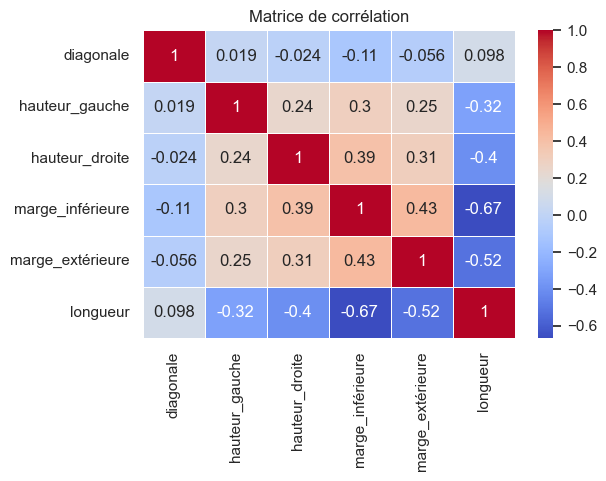

In [223]:
# Créer une matrice de corrélation
correlation_matrix = df_1.corr()

# Utiliser seaborn pour afficher un plot de corrélation en couleur
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de corrélation")
plt.show()

<p><FONT COLOR="#C7050E"><FONT SIZE=+1>On constate que, globalement, la corrélation est moyennement faible entre les différentes variables. Cela signifie qu'on peut considérer qu'elles sont indépendantes entre elles, ce qui est important pour la prédiction des valeurs manquantes de "marge_inférieure".</FONT></FONT></p>

<h4><i>4.2. Réaliser une régression linéaire multiple :</i></h4>

On peut régresser "marge_inférieure" en fonction des autres dimensions :

In [224]:
reg_multi = smf.ols('marge_inférieure~diagonale+hauteur_gauche+hauteur_droite+marge_extérieure+longueur', data=billets_prod).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:       marge_inférieure   R-squared:                       0.477
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     266.1
Date:                Mon, 20 Nov 2023   Prob (F-statistic):          2.60e-202
Time:                        09:23:37   Log-Likelihood:                -1001.3
No. Observations:                1463   AIC:                             2015.
Df Residuals:                    1457   BIC:                             2046.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           22.9948      9.656  

On constate ici que tous les paramètres sont significativement différents de 0, car leur p-valeur est inférieure à 5 %, le niveau de test que nous souhaitons.

Le 𝑅² et le  𝑅² ajusté sont d'environ 0.48. Cette valeur est plus élevée qu'en régression linéaire simple, et c'est logique, car lorsque l'on rajoute des variables explicatives potentielles, on accroît naturellement la valeur de ces  𝑅².


<p><FONT COLOR="#C7050E"><FONT SIZE=+1>On peut dire que toutes les dimensions sont significatives pour prédire les valeurs manquantes de "marge_inférieure".</FONT></FONT></p>

<h4><i>4.3. Prédire les valeurs manquantes pour la variable "marge_inférieure" :</i></h4>

Pour prédire les valeurs manquantes de "marge_inférieure", nous allons faire recours à un model de régression linéaire :

In [225]:
# Séparer les données en deux parties : avec et sans valeurs manquantes
test_data = billets_prod[billets_prod["marge_inférieure"].isnull()]
billets_prod.dropna(inplace = True)

# Créer X_train et y_train depuis "billets_prod"
y_train = billets_prod['marge_inférieure']
X_train = billets_prod.drop(['marge_inférieure','est_authentique'], axis=1)

In [226]:
test_data.head()

est_authentique  diagonale  hauteur_gauche  hauteur_droite  \
72                 0     171.94          103.89          103.45   
99                 0     171.93          104.07          104.18   
151                0     172.07          103.80          104.38   
197                0     171.45          103.66          103.80   
241                0     171.83          104.14          104.06   

     marge_inférieure  marge_extérieure  longueur  
72                NaN              3.25    112.79  
99                NaN              3.14    113.08  
151               NaN              3.02    112.93  
197               NaN              3.62    113.27  
241               NaN              3.02    112.36

In [227]:
X_train.shape

(1463, 5)

In [228]:
# Créer notre model de régression linéaire
model_l = LinearRegression()
model_l.fit(X_train, y_train)

LinearRegression()

In [229]:
# Créer le test dataset
X_test = test_data.drop(['est_authentique', 'marge_inférieure'], axis=1)

In [230]:
X_test.head()

diagonale  hauteur_gauche  hauteur_droite  marge_extérieure  longueur
72      171.94          103.89          103.45              3.25    112.79
99      171.93          104.07          104.18              3.14    113.08
151     172.07          103.80          104.38              3.02    112.93
197     171.45          103.66          103.80              3.62    113.27
241     171.83          104.14          104.06              3.02    112.36

In [231]:
# Appliquer le modèle sur le test set et prédire les valeurs manquantes
y_pred = model_l.predict(X_test)

# Calculer le coefficient de détermination R-squared mesurant la proportion de la variance de la variable dépendante 
model_l.score(X_train, y_train)

0.4773366973063957

In [232]:
# Ajouter les résultats de la régression pour les valeurs manquantes dans le test_data
test_data.loc[test_data.marge_inférieure.isnull(), 'marge_inférieure'] = y_pred

# afficher les valeur de y_pred
y_pred

C:\Users\eznat\AppData\Local\Temp\ipykernel_9308\3156244793.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[test_data.marge_inférieure.isnull(), 'marge_inférieure'] = y_pred


array([4.31852466, 4.39366755, 4.41045663, 4.31901423, 4.6506171 ,
       3.80330831, 4.17973608, 4.12744154, 4.13503418, 4.16053851,
       4.17742026, 3.76855378, 4.05876385, 4.29804709, 4.16060746,
       4.09406453, 4.43984627, 4.47065037, 4.34164322, 4.08041448,
       3.61430588, 4.37181147, 4.09362068, 4.24962896, 3.89374829,
       3.74633265, 4.23741481, 4.71053287, 4.13778022, 5.05027715,
       4.80214523, 5.067584  , 5.04756967, 4.77896717, 5.726993  ,
       5.18586214, 5.14004269])

In [233]:
# Afficher test_data
test_data.head()

est_authentique  diagonale  hauteur_gauche  hauteur_droite  \
72                 0     171.94          103.89          103.45   
99                 0     171.93          104.07          104.18   
151                0     172.07          103.80          104.38   
197                0     171.45          103.66          103.80   
241                0     171.83          104.14          104.06   

     marge_inférieure  marge_extérieure  longueur  
72           4.318525              3.25    112.79  
99           4.393668              3.14    113.08  
151          4.410457              3.02    112.93  
197          4.319014              3.62    113.27  
241          4.650617              3.02    112.36

In [234]:
# Concaténer "billets_prod" et "test_data" pour créer le dataframe final
df_billets_prod = pd.concat([billets_prod,test_data])

# Afficher le Dataframe obtenu
df_billets_prod.head()

est_authentique  diagonale  hauteur_gauche  hauteur_droite  \
0                0     171.81          104.86          104.95   
1                0     171.46          103.36          103.66   
2                0     172.69          104.48          103.50   
3                0     171.36          103.91          103.94   
4                0     171.73          104.28          103.46   

   marge_inférieure  marge_extérieure  longueur  
0              4.52              2.89    112.83  
1              3.77              2.99    113.09  
2              4.40              2.94    113.16  
3              3.62              3.01    113.51  
4              4.04              3.48    112.54

In [235]:
# Visualiser les valeurs manquantes :
df_billets_prod.isna().mean()

est_authentique     0.0
diagonale           0.0
hauteur_gauche      0.0
hauteur_droite      0.0
marge_inférieure    0.0
marge_extérieure    0.0
longueur            0.0
dtype: float64

In [236]:
df_billets_prod.shape

(1500, 7)

In [237]:
# Vérifier le types de chaque variable :
df_billets_prod.dtypes

est_authentique       int64
diagonale           float64
hauteur_gauche      float64
hauteur_droite      float64
marge_inférieure    float64
marge_extérieure    float64
longueur            float64
dtype: object

<h2><i>Etape 5 : Prédiction de l'authenticité des billets avec l’algorithme du k-means</i></h2>

<h3><i>1- Normalisation des données :</i></h3>

Nous commençons par séparer nos données. D'un coté `X` la matrice des données :

In [238]:
X = df_billets_prod.iloc[:, 1:].values
X[:5]

array([[171.81, 104.86, 104.95,   4.52,   2.89, 112.83],
       [171.46, 103.36, 103.66,   3.77,   2.99, 113.09],
       [172.69, 104.48, 103.5 ,   4.4 ,   2.94, 113.16],
       [171.36, 103.91, 103.94,   3.62,   3.01, 113.51],
       [171.73, 104.28, 103.46,   4.04,   3.48, 112.54]])

C'est bien un `np.array` :

In [239]:
type(X)

numpy.ndarray

La forme de cette matrice est conforme à nos attentes :

In [240]:
X.shape

(1500, 6)

In [241]:
names = df_billets_prod['est_authentique']
names

0       0
1       0
2       0
3       0
4       0
       ..
1303    1
1315    1
1347    1
1435    1
1438    1
Name: est_authentique, Length: 1500, dtype: int64

Et nos colonnes, nos features, dans une variable `features` :

In [242]:
features = df_billets_prod.columns[1:].tolist()
features

['diagonale',
 'hauteur_gauche',
 'hauteur_droite',
 'marge_inférieure',
 'marge_extérieure',
 'longueur']

<p>Scalons nos données :</p>

In [243]:
scaler = StandardScaler()

On fit :

On transforme :

In [244]:
X_scaled = scaler.fit_transform(X)
X_scaled[:5]

array([[-0.48653957,  2.77412327,  3.16324041,  0.0553898 , -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.08198744, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.12659056, -0.91256208,
         0.55190114],
       [-1.96149786, -0.39929381,  0.06049835, -1.30946288, -0.61049399,
         0.95307539],
       [-0.74875438,  0.83666863, -1.41407214, -0.67253163,  1.41767746,
        -0.15875038]])

On vise à avoir une moyenne à 0 et un écart type à 1 :

In [245]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

0    1    2    3    4    5
mean  0.0  0.0 -0.0  0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0

<h3><i>2. Clustering avec K-means :</i></h3>

In [246]:
# Effectuer le clustering avec K-Means
kmeans = KMeans(n_clusters=2, random_state=0, init='k-means++')
labels = kmeans.fit_predict(X)
labels

C:\Users\eznat\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 0, 0, ..., 1, 1, 1])

In [247]:
# On peut stocker nos centroïds dans une variable : 
centroids = kmeans.cluster_centers_
centroids

array([[171.98699803, 103.95165354, 103.81333661,   4.12414656,
          3.0582185 , 113.19615157],
       [171.89849174, 104.19301653, 104.14485537,   5.23776872,
          3.3472314 , 111.5918595 ]])

In [248]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [249]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(n_components=2)

In [250]:
pca.explained_variance_ratio_

array([0.43288253, 0.16956616])

In [251]:
X_proj = pca.transform(X_scaled)
X_proj = pd.DataFrame(X_proj, columns = ["PC1", "PC2"])
X_proj[:10]

PC1       PC2
0  1.644135  0.747843
1 -2.019910 -2.207492
2 -0.969864  2.620492
3 -1.377462 -1.818370
4  0.148712 -0.566722
5 -0.695783  0.427051
6  0.175920  1.302806
7 -1.151946 -0.383111
8 -0.854631  1.443058
9 -0.597479  1.742684

<h4><i>2.1. Représentation graphique du clustering K-Means :</i></h4>

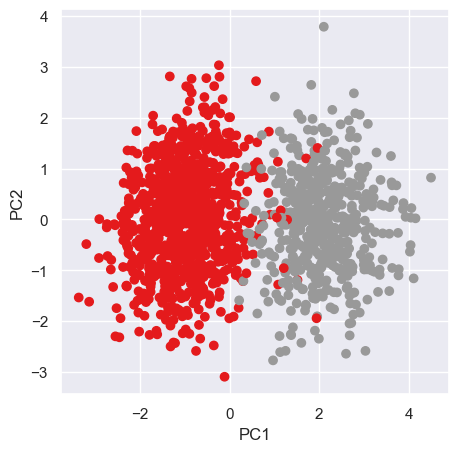

In [252]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

In [253]:
# Utiliser le scaler déjà entrainé 
centroids_scaled = scaler.fit_transform(centroids)

# Utiliser l'ACP déjà entrainée 
centroids_proj = pca.transform(centroids_scaled)

# Créer un dataframe pour plus de clarté
centroids_proj = pd.DataFrame(centroids_proj, 
                              columns = ["PC1", "PC2"], 
                              index=["cluster_0", "cluster_1"])

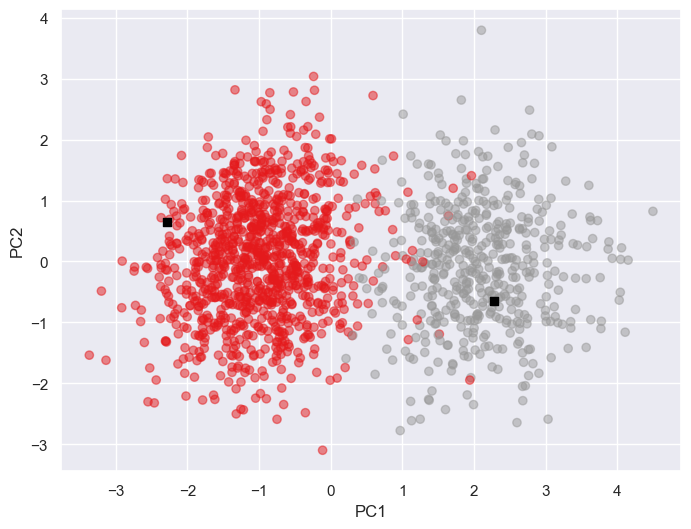

In [254]:
# Définir notre figure et son axe 
fig, ax = plt.subplots(1,1, figsize=(8,6))

# Afficher nos individus, avec une transparence de 50% (alpha=0.5) 
ax.scatter(X_proj.iloc[:, 0], X_proj.iloc[:, 1], c= labels, cmap="Set1", alpha =0.5)

# Afficher nos centroïdes, avec une couleur noire (c="black") et une frome de carré (marker="c") 
ax.scatter(centroids_proj.iloc[:, 0], centroids_proj.iloc[:, 1],  marker="s", c="black" )

# Spécifier les axes x et y
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.show()

<h4><i>2.2. Evaluation de la qualité du clustering :</i></h4>

<p>Intéressons nous au coefficient de silhouette (Silhouette Score) pour voir à quel point les points d'un même cluster sont similaires les uns aux autres par rapport aux autres clusters :</p>

In [255]:
from sklearn.metrics import silhouette_score

# Définir la fonction silhouette_score qui prend en charge les données et les étiquettes de cluster en entrée
silhouette_avg = silhouette_score(X, labels)

# Calculer "silhouette_avg" contenant le coefficient de silhouette moyen pour l'ensemble des données
print("Silhouette Score moyen :", silhouette_avg)

Silhouette Score moyen : 0.5140336532369679


<p><FONT COLOR="#C7050E"><FONT SIZE=+1>Le fait d'obtenir un score de silhouette moyen de 51%, cela suggère que notre algorithme de clustering K-Means a réussi à former deux clusters bien définis.</FONT></FONT></p>

<p>Nous pouvons également calculer l'indice de Dunn pour plus de précision :</p>

In [256]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import squareform

# Calculer la distance entre chaque paire de points dans X
distances = pairwise_distances(X)

# Calculer la distance minimale intra-cluster pour chaque cluster
min_intra_cluster_distances = []
for cluster_id in np.unique(labels):
    cluster_points = X[labels == cluster_id]
    cluster_distances = distances[labels == cluster_id][:, labels == cluster_id]
    np.fill_diagonal(cluster_distances, np.inf)
    min_distance = np.min(cluster_distances)
    min_intra_cluster_distances.append(min_distance)

# Calculer la distance maximale inter-cluster entre chaque paire de clusters différents
max_inter_cluster_distances = []
for cluster_id1 in np.unique(labels):
    for cluster_id2 in np.unique(labels):
        if cluster_id1 != cluster_id2:
            cluster1_points = X[labels == cluster_id1]
            cluster2_points = X[labels == cluster_id2]
            inter_cluster_distance = np.max(pairwise_distances(cluster1_points, cluster2_points))
            max_inter_cluster_distances.append(inter_cluster_distance)

# Calculer l'Indice de Dunn
min_intra_cluster_distances = np.array(min_intra_cluster_distances)
max_inter_cluster_distances = np.array(max_inter_cluster_distances)
dunn_index = np.min(min_intra_cluster_distances) / np.max(max_inter_cluster_distances)

print("Indice de Dunn :", dunn_index)

Indice de Dunn : 0.010514748594053948


<p><FONT COLOR="#C7050E"><FONT SIZE=+1>Un indice de Dunn proche de zéro suggère que les clusters sont très compacts et peu séparés.</FONT></FONT></p>

<h3><i>3- Analyse des clustrings et centroïdes :</i></h3>

<h4><i>3.1. Visualisation des valeurs des centroïdes :</i></h4>

<p>Commençons par visualiser les valeurs des centroïdes pour chaque variable :</p>

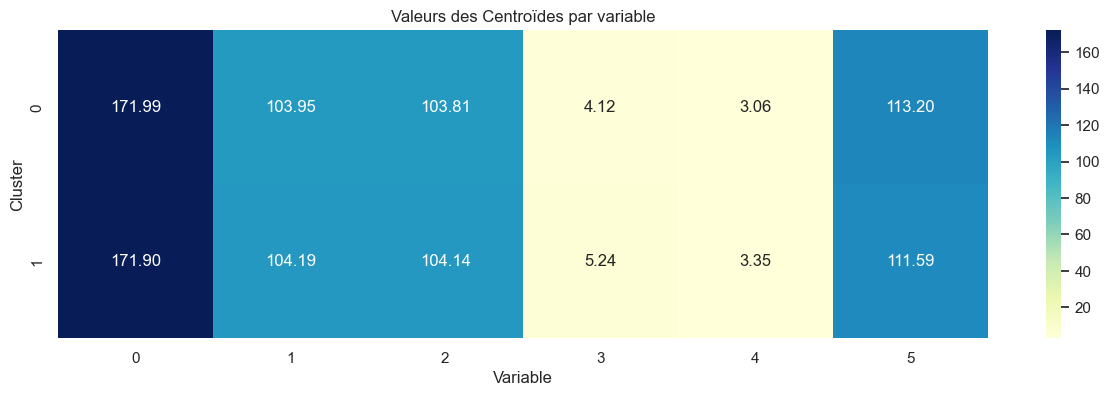

In [257]:
# Créer un heatmap pour visualiser les valeurs des centroïdes
plt.figure(figsize=(15, 4))
sns.heatmap(centroids, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Valeurs des Centroïdes par variable")
plt.xlabel("Variable")
plt.ylabel("Cluster")
plt.show()

<p><strong>Interprétations :</strong></p>
<ul>
    <li><strong>Cluster 0</strong> a des valeurs de centroïde élevées pour les variables 0, 1, 2 et 5. Cela suggère que les billets dans ce cluster ont tendance à avoir des valeurs élevées pour ces dimensions.</li>
    <li><strong>Cluster 1</strong> a les valeurs de centroïde élevées également pour les variables 0, 1, 2 et 5. Cela suggère que les billets dans ce cluster ont tendance à avoir des valeurs élevées pour ces dimensions.</li>
</ul>

<h4><i>3.2. Analyse des charges factorielles pour chaque composante principale :</i></h4>

<p>Pour définir les variables d'origine qui contribuent le plus à la distinction entre les clusters, nous pouvons calculer la différence moyenne ou la variance entre les clusters pour chaque variable :</p>

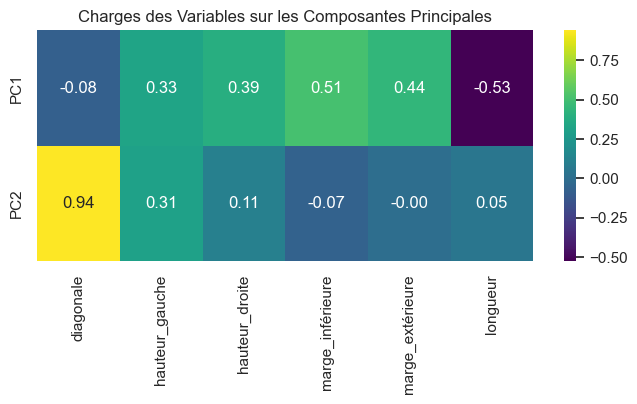

In [258]:
# Créer un DataFrame contenant les composantes principales
pca_df = pd.DataFrame(data=df_billets_prod, columns=['PC1', 'PC2'])

# Ajouter une colonne pour les labels de cluster
pca_df['Cluster'] = labels

# Créer une figure pour visualiser les charges des variables sur chaque composante principale
plt.figure(figsize=(8, 3))
sns.heatmap(pca.components_, cmap='viridis', annot=True, fmt='.2f', xticklabels=features, yticklabels=['PC1', 'PC2'])
plt.title('Charges des Variables sur les Composantes Principales')
plt.show()

<p><strong>Interprétations :</strong></p>
<ul>
    <li><strong>Pour PC1 :</strong> les variables d’origine "hauteur_gauche", "hauteur_droite", "marge_inférieure" et "marge_extérieure" sont les plus corrélées positivement avec PC1. La dimension "longueur" est la plus corrélée, négativement, avec PC1.</li>
    <li><strong>Pour PC2 :</strong> la variable d’origine "diagonale" est fortement corrélée positivement avec PC2.</li>
</ul>

<p>Nous pouvons aussi visualiser les valeurs des centroïdes pour chaque composante principale :</p>

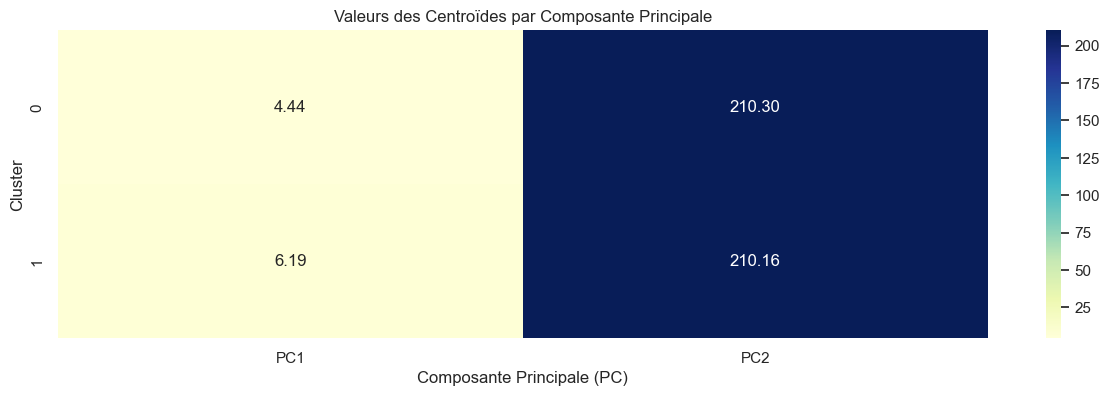

In [259]:
# Obtenir les centroides pour chaque composante principale à partir de l'objet PCA
centroids_pca = pca.transform(centroids)

# Créer un DataFrame à partir des centroides
centroids_pca_df = pd.DataFrame(centroids_pca, columns=[f"PC{i+1}" for i in range(centroids_pca.shape[1])])

# Créer un heatmap pour visualiser les valeurs des centroides par composante principale
plt.figure(figsize=(15, 4))
sns.heatmap(centroids_pca_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Valeurs des Centroïdes par Composante Principale")
plt.xlabel("Composante Principale (PC)")
plt.ylabel("Cluster")
plt.show()

On constate que les deux clusters ont les mêmes corrélations avec les deux composantes principales.

<h4><i>3.3. Analyse des corrélations entre les dimensions au sein de chaque cluster :</i></h4>

<h4><i><li><FONT COLOR="#006600">Création de matrice de corrélation par cluster :</FONT></li></i></h4>

<p>Commençons par créer nos matrices de corrélation :</p>

In [260]:
# Convertir le tableau NumPy en un DataFrame pandas
data = pd.DataFrame(X, columns=['diagonale',
 'hauteur_gauche',
 'hauteur_droite',
 'marge_inférieure',
 'marge_extérieure',
 'longueur'])

# Regrouper les identifiants de cluster attribués à chaque point de données
labels = kmeans.fit_predict(X)

# Ajouter une colonne "Cluster" à notre DataFrame "data"
data['Cluster'] = labels

# Créer un dictionnaire pour stocker les matrices de corrélation par cluster
correlation_matrices = {}

# Obtenir la liste des clusters uniques
unique_clusters = data['Cluster'].unique()

# Boucle à travers chaque cluster
for cluster in unique_clusters:
    # Sélectionner les lignes correspondant au cluster actuel
    cluster_data = data[data['Cluster'] == cluster]
    
    # Supprimer la colonne "Cluster" car nous n'avons plus besoin de cette information
    cluster_data = cluster_data.drop(columns=['Cluster'])
    
    # Calculer la matrice de corrélation pour le cluster actuel
    correlation_matrix = cluster_data.corr()
    
    # Stocker la matrice de corrélation dans le dictionnaire avec le nom du cluster comme clé
    correlation_matrices[f'Cluster {cluster}'] = correlation_matrix

C:\Users\eznat\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<p>Nous pouvons maintenant accéder à chaque matrice de corrélation par cluster :</p>

In [261]:
# Afficher correlation_matrices['Cluster 0'] pour le cluster 0
correlation_matrices['Cluster 0']

diagonale  hauteur_gauche  hauteur_droite  marge_inférieure  \
diagonale          1.000000        0.074095        0.066025          0.024014   
hauteur_gauche     0.074095        1.000000        0.077880          0.028608   
hauteur_droite     0.066025        0.077880        1.000000          0.061454   
marge_inférieure   0.024014        0.028608        0.061454          1.000000   
marge_extérieure   0.013256        0.056302        0.033522         -0.004976   
longueur          -0.003233       -0.005076        0.008341          0.009880   

                  marge_extérieure  longueur  
diagonale                 0.013256 -0.003233  
hauteur_gauche            0.056302 -0.005076  
hauteur_droite            0.033522  0.008341  
marge_inférieure         -0.004976  0.009880  
marge_extérieure          1.000000 -0.025370  
longueur                 -0.025370  1.000000

In [262]:
# Afficher correlation_matrices['Cluster 1'] pour le cluster 1
correlation_matrices['Cluster 1']

diagonale  hauteur_gauche  hauteur_droite  marge_inférieure  \
diagonale          1.000000        0.087510        0.001423         -0.043813   
hauteur_gauche     0.087510        1.000000        0.076130          0.010609   
hauteur_droite     0.001423        0.076130        1.000000         -0.003874   
marge_inférieure  -0.043813        0.010609       -0.003874          1.000000   
marge_extérieure   0.064046       -0.026206        0.059775         -0.121683   
longueur          -0.083895        0.028679        0.030353          0.036548   

                  marge_extérieure  longueur  
diagonale                 0.064046 -0.083895  
hauteur_gauche           -0.026206  0.028679  
hauteur_droite            0.059775  0.030353  
marge_inférieure         -0.121683  0.036548  
marge_extérieure          1.000000 -0.080433  
longueur                 -0.080433  1.000000

<h4><i><li><FONT COLOR="#006600">Représentation des matrices de corrélation dans des heatmaps :</FONT></li></i></h4>

<p>Nous allons stocker les matrices de corrélation dans un dictionnaire nommé "correlation_matrices" et le représenter sous forme de heatmap :</p>

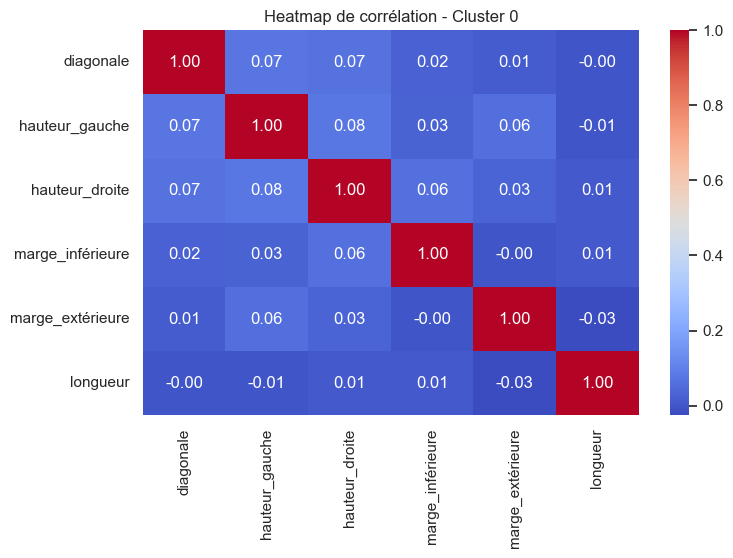

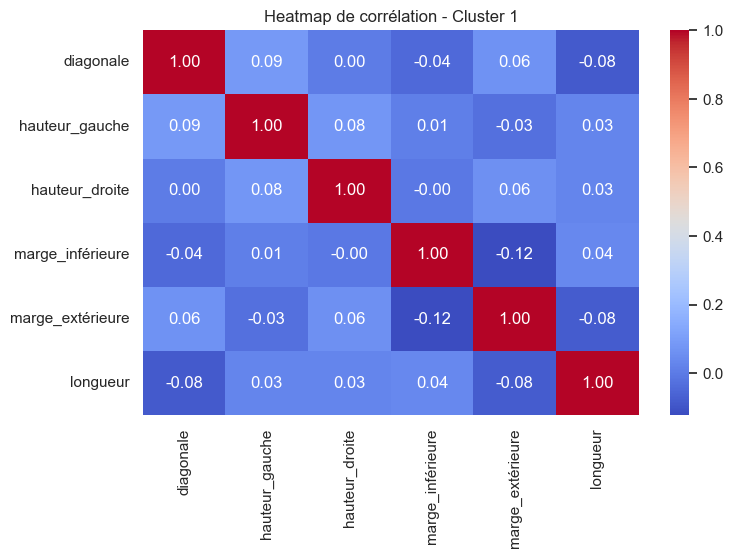

In [263]:
# Boucle à travers chaque matrice de corrélation et créer un heatmap
for cluster, correlation_matrix in correlation_matrices.items():
    plt.figure(figsize=(8, 5))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Heatmap de corrélation - {cluster}')
    plt.show()

<p><FONT COLOR="#C7050E"><FONT SIZE=+1>On peut conclure que les corrélations sont très faibles entre les différentes dimensions au sein de chaque cluster.</FONT></FONT></p>

<h4><i>3.4. Répartition des billets au sein des clusters :</i></h4>

<strong>Cluster 0 :</strong>

<p>Nous pouvons visualiser la répartition des billets dans le cluster 0 dans un espace bidimensionnel en fonction des deux composantes principales "PC1" et "PC2" :</p>

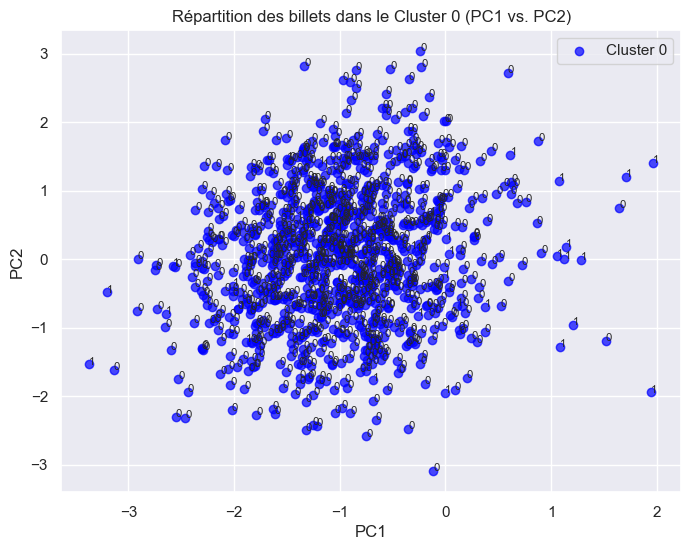

In [264]:
# Remplacer X_proj par votre DataFrame contenant les valeurs de PC1 et PC2
data = pd.concat([data, X_proj], axis=1)

# Données du cluster 0
cluster_0_data = data[data['Cluster'] == 0]

# Indices des individus du cluster 0
cluster_0_indices = cluster_0_data.index

# Noms des individus du cluster 0
cluster_0_names = names[cluster_0_indices] 

# Noms des individus du cluster 0
cluster_0_names = names[cluster_0_indices]

# Extrait les valeurs des composantes principales PC1 et PC2 pour le cluster 0
pc1_cluster_0 = cluster_0_data["PC1"]
pc2_cluster_0 = cluster_0_data["PC2"]

# Créer un graphique de dispersion pour visualiser la répartition du cluster 0
plt.figure(figsize=(8, 6))
plt.scatter(pc1_cluster_0, pc2_cluster_0, c="blue", label="Cluster 0", alpha=0.7)

# Annoter chaque point avec le nom de l'individu correspondant
for i, name in enumerate(cluster_0_names):
    plt.annotate(name, (pc1_cluster_0.iloc[i], pc2_cluster_0.iloc[i]), fontsize=8)

# Afficher le graphique
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Répartition des billets dans le Cluster 0 (PC1 vs. PC2)")
plt.legend()
plt.grid(True)
plt.show()

Nous pouvons calculer le nombre de vrais et de faux billets dans Cluster 0 :

In [265]:
# Ajouter une colonne "cluster" à votre dataframe de base "df_billets_prod"
df_billets_prod['cluster'] = labels

# Compter le nombre de vrais et de faux billets dans Cluster 0
cluster_0 = df_billets_prod[df_billets_prod['cluster'] == 0]
counts = cluster_0['est_authentique'].value_counts()

# Afficher les résultats
counts

0    997
1     19
Name: est_authentique, dtype: int64

<strong>Cluster 1 :</strong>

<p>Nous pouvons aussi visualiser la répartition des billets dans le cluster 1 dans un espace bidimensionnel en fonction des deux  composantes principales PC1 et PC2 :</p>

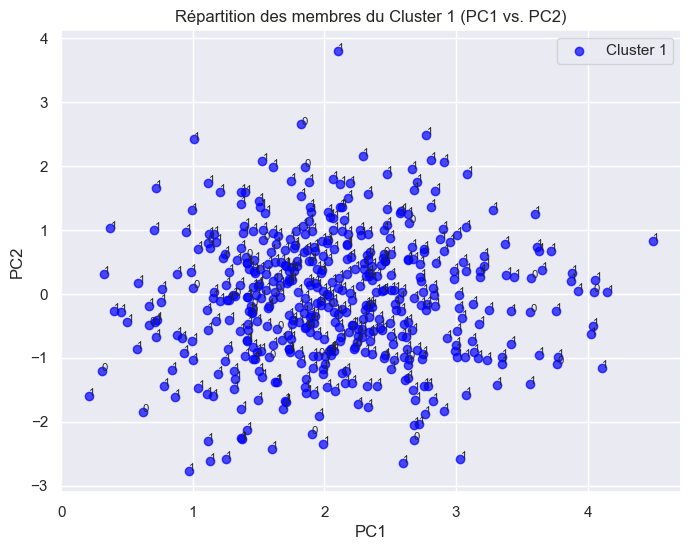

In [266]:
# Données du cluster 1
cluster_1_data = data[data['Cluster'] == 1]

# Indices des individus du cluster 1
cluster_1_indices = cluster_1_data.index

# Noms des individus du cluster 1
cluster_1_names = names[cluster_1_indices] 

# Noms des individus du cluster 1
cluster_1_names = names[cluster_1_indices] 

# Extrait les valeurs des composantes principales PC1 et PC2 pour le cluster 1
pc1_cluster_1 = cluster_1_data["PC1"]
pc2_cluster_1 = cluster_1_data["PC2"]

# Créer un graphique de dispersion pour visualiser la répartition du cluster 1
plt.figure(figsize=(8, 6))
plt.scatter(pc1_cluster_1, pc2_cluster_1, c="blue", label="Cluster 1", alpha=0.7)

# Annoter chaque point avec le nom de l'individu correspondant
for i, name in enumerate(cluster_1_names):
    plt.annotate(name, (pc1_cluster_1.iloc[i], pc2_cluster_1.iloc[i]), fontsize=8)

# Afficher le graphique
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Répartition des membres du Cluster 1 (PC1 vs. PC2)")
plt.legend()
plt.grid(True)
plt.show()

Nous pouvons calculer le nombre de vrais et de faux billets dans cluster 1 :

In [267]:
# Compter le nombre de vrais et de faux billets dans Cluster 0
cluster_1 = df_billets_prod[df_billets_prod['cluster'] == 1]
counts = cluster_1['est_authentique'].value_counts()

# Afficher les résultats
counts

1    481
0      3
Name: est_authentique, dtype: int64

<li><strong>Interprétations :</strong></li>

A partir du clustering Kmeans, nous avons obtenu deux clusters. Le Cluster 0 contient 997 vrais billets et 19 faux billets, tandis que le Cluster 1 contient 481 faux billets et 3 vrais billets 1.


<p><FONT COLOR="#C7050E"><FONT SIZE=+1>Ces résultats indiquent que le clustering K-means a réussi à séparer les vrais billets des faux billets en deux groupes distincts.</FONT></FONT></p>

<h3><i>4- Evaluer le modèle K-means pour la prédiction :</i></h3>

In [268]:
# Récupérer les clusters attribués à chaque billet
clusters = labels

# Ajouter la colonne "cluster" au dataframe de base
df_billets_prod['cluster']= clusters

# Inverser les étiquettes des clusters
df_billets_prod['cluster'].replace([1,0],[0,1],inplace = True)
df_billets_prod

est_authentique  diagonale  hauteur_gauche  hauteur_droite  \
0                   0     171.81          104.86          104.95   
1                   0     171.46          103.36          103.66   
2                   0     172.69          104.48          103.50   
3                   0     171.36          103.91          103.94   
4                   0     171.73          104.28          103.46   
...               ...        ...             ...             ...   
1303                1     172.17          104.49          103.76   
1315                1     172.08          104.15          104.17   
1347                1     171.72          104.46          104.12   
1435                1     172.66          104.33          104.41   
1438                1     171.90          104.28          104.29   

      marge_inférieure  marge_extérieure  longueur  cluster  
0             4.520000              2.89    112.83        1  
1             3.770000              2.99    113.09        1  
2             4.400000              2.94    113.16        1  
3             3.620000              3.01    113.51        1  
4             4.040000              3.48    112.54        1  
...                ...               ...       ...      ...  
1303          5.047570              2.93    111.21        0  
1315          4.778967              3.40    112.29        0  
1347          5.726993              3.61    110.31        0  
1435          5.185862              3.56    111.47        0  
1438          5.140043              3.24    111.49        0  

[1500 rows x 8 columns]

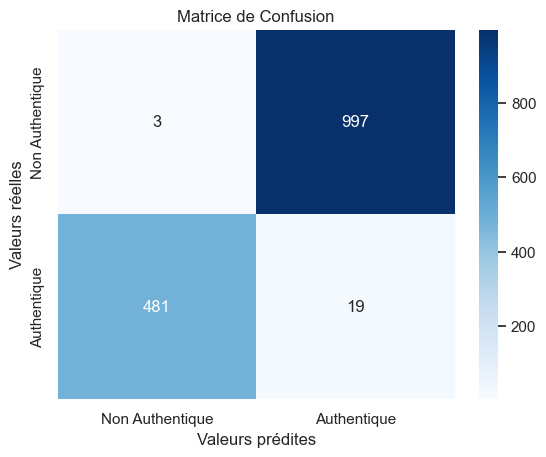

In [269]:
# Générer la matrice de confusion en nombre de billets placés

y_actu = df_billets_prod['est_authentique']
y_pred = df_billets_prod['cluster']

# Matrice de confusion
conf_matrix = confusion_matrix(y_actu, y_pred)

# Affichage de la matrice de confusion avec seaborn
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Authentique', 'Authentique'], yticklabels=['Non Authentique', 'Authentique'])
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de Confusion')
plt.show()

In [270]:
# Générer la matrice de confusion en %
y_actu = pd.Series(df_billets_prod['est_authentique'], name='Actual')
y_pred = pd.Series(df_billets_prod['cluster'], name='Predicted')
df_confusion = pd.crosstab(y_actu, y_pred, normalize="index")
df_confusion

Predicted      0      1
Actual                 
0          0.003  0.997
1          0.962  0.038

Parmi les 1000 vrais billets :
<ul>
    <li>997 ont été bien placés (recall), soit 99.7%</li>
    <li>3 ont été prédis comme étant vrais alors qu'ils étaient faux, soit 3%</li>
</ul>

Parmi les 500 faux billets :
<ul>
    <li>481 sont biens placés, soit 96.2%</li>
    <li>19 sont prédis comme étant faux alors qu'ils sont vrais en réalité, soit 3.8%</li>
</ul>

In [271]:
from sklearn.metrics import classification_report
print(classification_report(y_actu,y_pred))

              precision    recall  f1-score   support

           0       0.01      0.00      0.00      1000
           1       0.02      0.04      0.03       500

    accuracy                           0.01      1500
   macro avg       0.01      0.02      0.01      1500
weighted avg       0.01      0.01      0.01      1500



<p><FONT COLOR="#C7050E"><FONT SIZE=+1>Nos résultats montrent un modèle qui n'est pas aussi performant avec une faible précision et un faible rappel. Cela indique que, même si notre modèle a bien généralisé sur les données de test, il est important de rappeler que l'algorithme K-means est une technique de clustering non supervisée qui ne prend pas en compte les étiquettes de classe réelles. Par conséquent, il est possible que certains billets dans chaque cluster soient mal étiquetés.</FONT></FONT></p>

<h3><i>5- Tester l'authenticité à partir des centroïdes du modèle K-means :</i></h3>

Pour utiliser les centroïdes de notre clustering K-means dans la prédiction de l’authenticité des billets, nous pouvons se baser sur la distance euclidienne entre les centroïdes et les billets. Les billets qui sont plus proches d’un centroïde sont plus susceptibles d’appartenir à la même classe que le centroïde :

In [272]:
# Créer un DataFrame avec 60 billets et des dimensions aléatoires
np.random.seed(42)
nouveaux_billets = pd.DataFrame({
    'diagonale': np.random.uniform(171.50, 172.50, 60),
    'hauteur_gauche': np.random.uniform(103.50, 104.50, 60),
    'hauteur_droite': np.random.uniform(103.50, 104.50, 60),
    'marge_inférieure': np.random.uniform(3.00, 6.00, 60),
    'marge_extérieure': np.random.uniform(2.50, 3.50, 60),
    'longueur': np.random.uniform(111.00, 114.00, 60)
})

# Afficher le DataFrame
nouveaux_billets.head()

diagonale  hauteur_gauche  hauteur_droite  marge_inférieure  \
0  171.874540      103.888677      104.307440          4.023199   
1  172.450714      103.771349      104.396091          3.340421   
2  172.231994      104.328738      103.818003          5.774081   
3  172.098658      103.856753      103.610052          5.632018   
4  171.656019      103.780935      103.727935          3.773825   

   marge_extérieure    longueur  
0          3.440459  111.155045  
1          3.453929  112.594064  
2          3.414864  112.621905  
3          2.870159  112.912290  
4          2.515457  113.178274

In [273]:
from scipy.spatial.distance import cdist

# Calcul des distances euclidiennes
distances = cdist(nouveaux_billets, centroids)

# Attribution des labels des clusters aux nouveaux billets
predicted_clusters = np.argmin(distances, axis=1)

# Ajout des labels prédits au dataframe
df_nouveaux_billets = pd.DataFrame(nouveaux_billets, columns=features)
df_nouveaux_billets['predicted_cluster'] = predicted_clusters

# Affichage du résultat
df_nouveaux_billets.head()

diagonale  hauteur_gauche  hauteur_droite  marge_inférieure  \
0  171.874540      103.888677      104.307440          4.023199   
1  172.450714      103.771349      104.396091          3.340421   
2  172.231994      104.328738      103.818003          5.774081   
3  172.098658      103.856753      103.610052          5.632018   
4  171.656019      103.780935      103.727935          3.773825   

   marge_extérieure    longueur  predicted_cluster  
0          3.440459  111.155045                  1  
1          3.453929  112.594064                  0  
2          3.414864  112.621905                  1  
3          2.870159  112.912290                  0  
4          2.515457  113.178274                  0

In [274]:
# Calculer le nombre de vrais et de faux billets
nombre_faux = df_nouveaux_billets[df_nouveaux_billets['predicted_cluster'] == 0].shape[0]
nombre_vrais = df_nouveaux_billets[df_nouveaux_billets['predicted_cluster'] == 1].shape[0]

# Afficher les résultats
print(f"Nombre de vrais billets : {nombre_vrais}")
print(f"Nombre de faux billets : {nombre_faux}")

Nombre de vrais billets : 27
Nombre de faux billets : 33


<p><FONT COLOR="#C7050E"><FONT SIZE=+1>Notre modèle K-means a identifié 33 vrais billets (proches du centroïde du Cluster 1) et 27 faux (proches du centroïde du Cluster 0).</FONT></FONT></p>

<h2><i>Etape 5 : Prédiction de l'authenticité avec une regression logistique</i></h2>

<h3><i>1- Visualisation des nuages de points :</i></h3>

Commençons par visualiser des nuages de points pour différentes dimensions selon l'authenticité des billets :

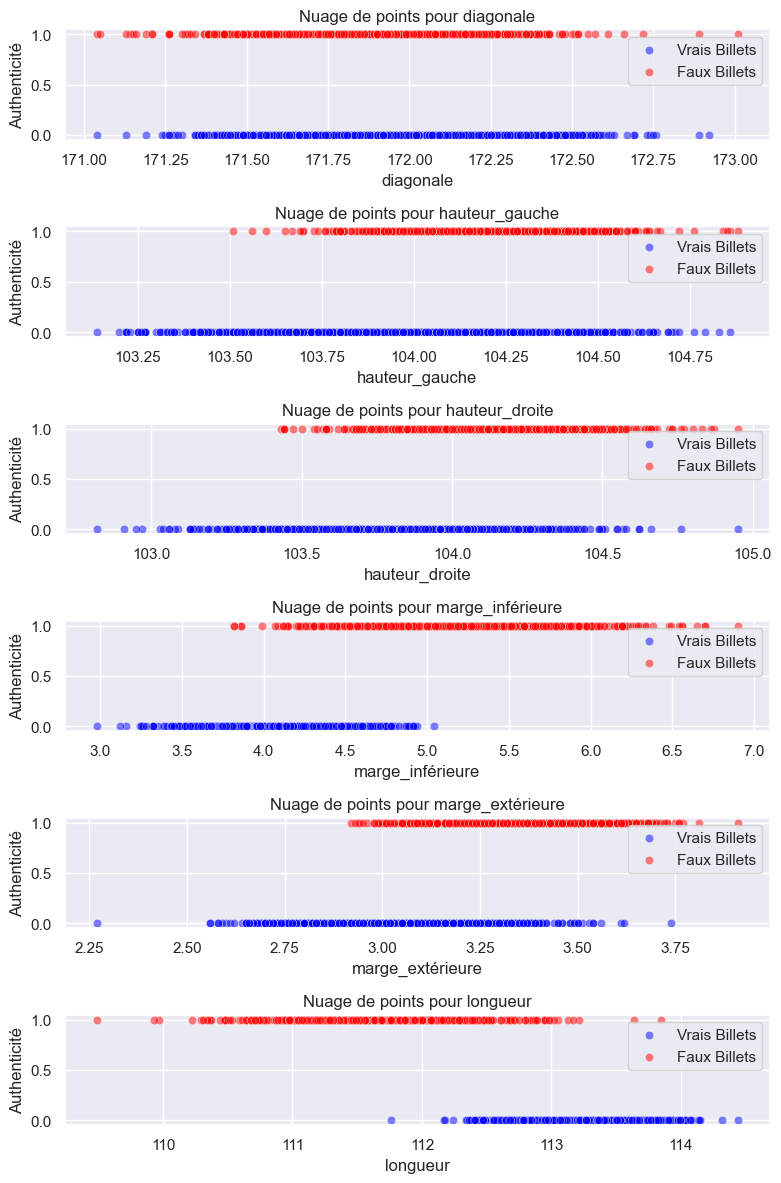

In [275]:
# Supprimer la colonne "cluster"
df_billets_prod_1 = df_billets_prod.drop("cluster", axis=1)

# Séparer le dataframe en deux parties : vrais et faux billets
vrais_billets = df_billets_prod_1[df_billets_prod_1["est_authentique"] == 0]
faux_billets = df_billets_prod_1[df_billets_prod_1["est_authentique"] == 1]

# Liste des colonnes pour lesquelles nous souhaitons créer des nuages de points
columns = ["diagonale", "hauteur_gauche", "hauteur_droite", "marge_inférieure", "marge_extérieure", "longueur"]

# Créer un subplot pour chaque dimension
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(8, 12))

# Parcourir chaque dimension et créer un nuage de points
for i, col in enumerate(columns):
    # Créer un nuage de points pour les vrais billets en bleu
    sns.scatterplot(data=vrais_billets, x=col, y="est_authentique", label="Vrais Billets", color="blue", alpha=0.5, ax=axes[i])

    # Créer un nuage de points pour les faux billets en rouge
    sns.scatterplot(data=faux_billets, x=col, y="est_authentique", label="Faux Billets", color="red", alpha=0.5, ax=axes[i])

    # Ajouter des légendes et un titre à chaque subplot
    axes[i].set_title(f"Nuage de points pour {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Authenticité")

# Ajuster l'espacement entre les subplots
plt.tight_layout()

# Afficher les nuages de points
plt.show()

Il y a des 'VRAI' et des 'FAUX' billets, mais il est ici difficile de dire s'ils y'a plus ou moins de faux billets en fonction de la mesure de chaque dimension.

<p><FONT COLOR="#C7050E"><FONT SIZE=+1>On voit bien qu'une régression linéaire sur un tel jeu de données n'aurait aucun sens.</FONT></FONT></p>

<h3><i>2- Effectuer la régression logistique classique :</i></h3>

Effectuons donc une régression logistique de l'authenticité en fonction des différentes dimensions :

In [276]:
reg_log1 = smf.glm('est_authentique~diagonale+hauteur_gauche+hauteur_droite+marge_inférieure+marge_extérieure+longueur',
                   data=df_billets_prod_1, family=sm.families.Binomial()).fit()
print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        est_authentique   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1493
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -42.342
Date:                Mon, 20 Nov 2023   Deviance:                       84.685
Time:                        09:23:47   Pearson chi2:                 2.65e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7038
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          204.5582    241.768  

On constate ici que les variables "diagonale" et "hauteur_gauche" ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons.

Les autres variables ont des p-valeurs qui sont inférieures au niveau de test de 5 %, ce qui nous indique qu'elles sont bien significatives.

On va donc maintenant retirer les variables non significatives. On commence par la moins significative : "diagonale", car elle a une p-valeur de 0.95.

In [277]:
reg_log1 = smf.glm('est_authentique~hauteur_gauche+hauteur_droite+marge_inférieure+marge_extérieure+longueur',
                   data=df_billets_prod, family=sm.families.Binomial()).fit()
print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        est_authentique   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1494
Model Family:                Binomial   Df Model:                            5
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -42.344
Date:                Mon, 20 Nov 2023   Deviance:                       84.689
Time:                        09:23:47   Pearson chi2:                 2.66e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7038
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          193.1473    157.681  

On voit alors que c'est maintenant "hauteur_gauche", avec une p-valeur de 0.12, qui est la moins significative. On l'enlève donc.

In [278]:
reg_log1 = smf.glm('est_authentique~hauteur_droite+marge_inférieure+marge_extérieure+longueur',
                   data=df_billets_prod_1, family=sm.families.Binomial()).fit()
print(reg_log1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        est_authentique   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1495
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -43.586
Date:                Mon, 20 Nov 2023   Deviance:                       87.173
Time:                        09:23:47   Pearson chi2:                 3.24e+03
No. Iterations:                    10   Pseudo R-squ. (CS):             0.7033
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          323.4452    139.532  

<p><FONT COLOR="#C7050E"><FONT SIZE=+1>On remarque qu'à présent, tous les paramètres sont significatifs, avec des p-valeur inférieure à 5%.</FONT></FONT></p>

<h3><i>3- Entrainer et évaluer le model choisi :</i></h3>

Pour tester la précision de notre modèle de régression logistique, nous pouvons utiliser plusieurs mesures d'évaluation et techniques, telles que la précision (Accuracy), le rapport (Recall), le score F1, la matrice de confusion, le rapport de classification et la courbe ROC :

In [279]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Diviser les données en ensembles d'entraînement et de test
X = df_billets_prod_1.drop(['est_authentique'], axis=1)
y = df_billets_prod_1['est_authentique']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=2)

# créer le model de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédiser l'authenticité sur les données de test
y_pred = model.predict(X_test)

# Obtenir les probabilités prédites sur l'ensemble de test
probabilites = model.predict_proba(X)

# Ajouter la colonne "prediction" au dataframe "df_billets_prod_1"
df_billets_prod_1['prediction']=model.predict(X)

In [280]:
# Évaluer la précision
model_acc = accuracy_score(df_billets_prod_1['est_authentique'],df_billets_prod_1['prediction'])

print(f"Précision : {model_acc}")

Précision : 0.988


In [281]:
from sklearn.metrics import recall_score, f1_score
 
# Calcul du rappel
recall = recall_score(df_billets_prod_1['est_authentique'],df_billets_prod_1['prediction'])

# Calcul du score F1
f1 = f1_score(df_billets_prod_1['est_authentique'],df_billets_prod_1['prediction'])

# Afficher du rappel
print("Recall : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))

Recall : 0.98
Score F1 : 0.98


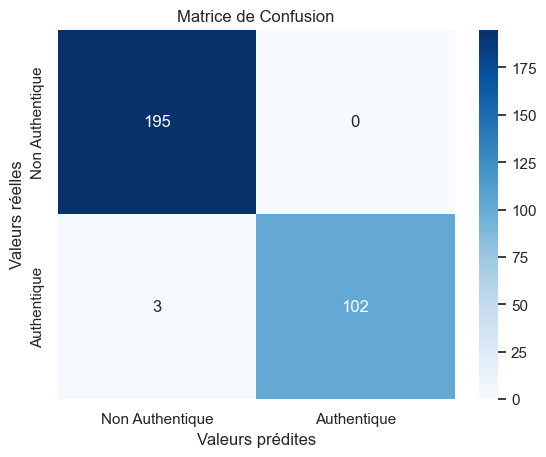

In [282]:
# Créer la matrice de confusion à partir des prédictions du modèle
conf_matrix = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Authentique', 'Authentique'], yticklabels=['Non Authentique', 'Authentique'])
plt.xlabel('Valeurs prédites')
plt.ylabel('Valeurs réelles')
plt.title('Matrice de Confusion')
plt.show()

In [283]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       195
           1       1.00      0.97      0.99       105

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



In [284]:
# Afficher la matrice de confusion sur l'ensemble de données
confusion_mat = pd.crosstab(df_billets_prod_1['est_authentique'],df_billets_prod_1['prediction'])

print("Matrice de Confusion :\n", confusion_mat)

Matrice de Confusion :
 prediction         0    1
est_authentique          
0                994    6
1                 12  488


In [285]:
# Calculer le taux d'erreur
vrai_negatif = confusion_mat.loc[0,0]
faux_positif = confusion_mat.loc[0,1]
faux_negatif = confusion_mat.loc[1,0]
vrai_positif = confusion_mat.loc[1,1]

taux_erreur = (faux_positif + faux_negatif) / (vrai_negatif+faux_positif+faux_negatif+vrai_positif)
taux_erreur

0.012

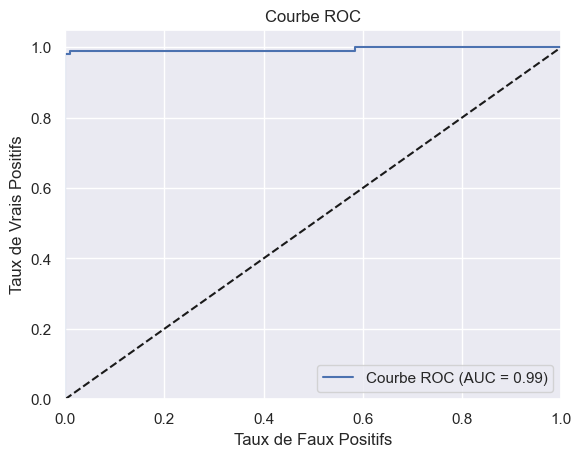

In [286]:
# Calculer la courbe ROC et l'AUC-ROC
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)  # Spécifier pos_label=1
auc = roc_auc_score(y_test, y_pred_proba)

# Tracer la courbe de ROC
plt.figure()
plt.plot(fpr, tpr, label=f"Courbe ROC (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

Les résultats de notre modèle de régression logistique sont très encourageants :

L'exactitude (Accuracy) de 0.987 indique que le modèle a correctement classé environ 98.7% des observations.

La matrice de confusion montre que le modèle a généré 195 vrais positifs (Vrais billets correctement classés) et 102 vrais négatifs (Faux billets correctement classés), avec 0 faux positifs (Faux billets classés comme Vrais) et 3 faux négatif (Vrais billets classés comme Faux).

Une précision de 0,98 signifie que parmi les billets classés comme Vrais par le modèle, 98% sont réellement Vrais. Un rappel de 0.96 pour la classe 1 (Faux) signifie que le modèle a réussi à capturer 96% des vrais Faux billets.

Une AUC de 0.99 pour la courbe ROC signifie que le modèle est capable de distinguer parfaitement entre les deux classes, sans presque aucune confusion.

Le rapport de classification (Classification Report) montre de bonnes valeurs de précision, rappel (recall), et score F1 pour les deux classes (Vrais et Faux).
Un taux de rappel (Recall) élevé de 0,96 suggère que le modèle a bien réussi à identifier la grande majorité des cas positifs, ce qui est généralement souhaitable dans de nombreuses applications.

Un score F1 de 0,98 est une mesure de la performance d'un modèle de classification, et il indique que le modèle a une performance très élevée en termes de précision et de rappel, ce qui est généralement un résultat excellent.

<p><FONT COLOR="#C7050E"><FONT SIZE=+1>Dans l'ensemble, ces résultats permettent de dire que notre modèle de régression logistique a de bonnes performances pour distinguer les Vrais des Faux billets.</FONT></FONT></p>

<h3><i>4- Evaluer le modèle de régression logistique avec Cross-Validation :</i></h3>

Nous réalisons la régression logistique avec <strong>Cross-Validation</strong> afin d'évaluer les performances de notre modèle de régression logistique de manière plus fiable et robuste :

In [287]:
from sklearn.linear_model import LogisticRegressionCV

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=2)

# Créer le model de régression logistique avec Cross-Validation
model_CV = LogisticRegressionCV(max_iter=1000) # Augmenter le nombre maximal d'itérations
model_CV.fit(X_train, y_train)

# # Faire des prédictions sur l'ensemble de test
y_predicted = model_CV.predict(X_test)

In [288]:
# Afficher les scores de précision du modèle sur les ensembles d'entraînement et de test
print('Train_score', model_CV.score(X_train,y_train))
print('Test_score', model_CV.score(X_test,y_test))

Train_score 0.9908333333333333
Test_score 0.9933333333333333


In [289]:
# Ajouter la colonne "prediction" au dataframe "df_billets_prod_1"
df_billets_prod_1['prediction_1']=model_CV.predict(X)

# Afficher la matrice de confusion sur l'ensemble de données
confusion_mat_CV = pd.crosstab(df_billets_prod_1['est_authentique'],df_billets_prod_1['prediction_1'])

print("Matrice de Confusion :\n", confusion_mat_CV)

Matrice de Confusion :
 prediction_1       0    1
est_authentique          
0                996    4
1                  9  491


In [290]:
from sklearn.metrics import classification_report

# Afficher le rapport de classification détaillé
print(classification_report(y_test,y_predicted))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       195
           1       1.00      0.98      0.99       105

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



<p><FONT COLOR="#C7050E"><FONT SIZE=+1>Ces résultats montrent que notre modèle de régression logistique avec Cross-Validation a une très bonne performance avec une précision, un rappel élevé et un F1-score très élevés. L'exactitude de 99% indique que la grande majorité des prédictions sont correctes.</FONT></FONT></p>

<h3><i>5- Prédire l'authenticité à partir du modèle de régression logistique avec Cross-Validation :</i></h3>

On peut également tester notre modèle de régression logistique avec Cross-Validation sur les billets déjà utiliser avec le modèle K-means :

In [291]:
# Prédire l'authenticité des nouveaux billets
predictions = model_CV.predict(nouveaux_billets)

# Calculer le nombre de vrais et de faux billets
nombre_vrais_billets = pd.Series(predictions).value_counts().get(0, 0)
nombre_faux_billets = pd.Series(predictions).value_counts().get(1, 0)

# Afficher les résultats
print("Nombre de vrais billets :", nombre_vrais_billets)
print("Nombre de faux billets :", nombre_faux_billets)

Nombre de vrais billets : 31
Nombre de faux billets : 29


<p><FONT COLOR="#C7050E"><FONT SIZE=+1>Notre modèle de régression logistique avec Cross-Validation semble être plus précis que le modèle K-means, car il détecte 29 faux billets au lieu de 27.</FONT></FONT></p>

<h2><i>Etape 6 : Conclusion générale</i></h2>

Compte tenu des résultats des 3 modèles testés, il apparait que le <strong>modèle de régression logistique avec Cross-Validation</strong> comprend les meilleurs résultats.

<p><FONT COLOR="#C7050E"><FONT SIZE=+1>Ce modèle sera utilisé pour tester les futurs billets.</FONT></FONT></p>

Pour ce faire, il convient d'enregistrer le modèle entrainé grâce à la librairie <strong>joblib</strong>.

In [292]:
# Enregistrer le modèle retenu dans joblib
from joblib import dump, load
dump(model_CV, "Logistic_Trained_model.joblib")

['Logistic_Trained_model.joblib']

<h2><i>Etape 6 : Utilisation du modèle final retenu sur un format type de fichiers de billets nommé "billets_production.csv"</i></h2>

Pour pouvoir utiliser le modèle final retenu, il faut commencer par le charger depuis la bibliothèque "joblib" :

In [293]:
# Charger le modèle de régression logistique CV depuis joblib
model_CV = load("Logistic_Trained_model.joblib")

In [294]:
# Importer et afficher le fichier "billets_production.csv"
billets_production = pd.read_csv("billets_production.csv", decimal=".", index_col=0, delimiter=',')

# Afficher le Dataframe
billets_production.head()

height_left  height_right  margin_low  margin_up  length   id
diagonal                                                               
171.76         104.01        103.54        5.21       3.30  111.42  A_1
171.87         104.17        104.13        6.00       3.31  112.09  A_2
172.00         104.58        104.29        4.99       3.39  111.57  A_3
172.49         104.55        104.34        4.44       3.03  113.20  A_4
171.65         103.63        103.56        3.77       3.16  113.33  A_5

In [295]:
# Réindexer le Dataframe "billets_prod"
billets_production = billets_production.reset_index()

In [296]:
# Renommer les colonnes pour que les données soient compatibles avec le modèle
billets_production = billets_production.rename(columns={"diagonal": "diagonale", "height_left": "hauteur_gauche", "height_right": "hauteur_droite", "margin_low": "marge_inférieure", "margin_up": "marge_extérieure", "length": "longueur", "id": "Id_billet"})
billets_production.head()

diagonale  hauteur_gauche  hauteur_droite  marge_inférieure  \
0     171.76          104.01          103.54              5.21   
1     171.87          104.17          104.13              6.00   
2     172.00          104.58          104.29              4.99   
3     172.49          104.55          104.34              4.44   
4     171.65          103.63          103.56              3.77   

   marge_extérieure  longueur Id_billet  
0              3.30    111.42       A_1  
1              3.31    112.09       A_2  
2              3.39    111.57       A_3  
3              3.03    113.20       A_4  
4              3.16    113.33       A_5

In [297]:
import tkinter as tk
from tkinter import messagebox
import sys

# Vérifier la forme du fichier
liste_X = ["diagonale", "hauteur_gauche", "hauteur_droite","marge_inférieure", "marge_extérieure", "longueur", "Id_billet"]
if all([item in billets_production.columns for item in liste_X]):
    print("Le fichier est correct. Voici un aperçu des données :\n\n", billets_production)
else:
    messagebox.showerror(title="Erreur d'importation du fichier", message="Attention, les colonnes du fichier ne correspondent pas à la trame attendue !")
    sys.exit()

Le fichier est correct. Voici un aperçu des données :

    diagonale  hauteur_gauche  hauteur_droite  marge_inférieure  \
0     171.76          104.01          103.54              5.21   
1     171.87          104.17          104.13              6.00   
2     172.00          104.58          104.29              4.99   
3     172.49          104.55          104.34              4.44   
4     171.65          103.63          103.56              3.77   

   marge_extérieure  longueur Id_billet  
0              3.30    111.42       A_1  
1              3.31    112.09       A_2  
2              3.39    111.57       A_3  
3              3.03    113.20       A_4  
4              3.16    113.33       A_5  


In [298]:
# Vérifier les valeurs manquantes
if((billets_production.isnull().sum(axis = 0)).sum() > 0):
    messagebox.showerror(title="Valeurs manquantes détectées", message="Attention, des valeurs manquantes ont été détectées dans le fichier ! Traitement impossible en l'état.")
    sys.exit()
else :
    print("Aucune valeur manquante détectée, le traitement peut continuer.")

Aucune valeur manquante détectée, le traitement peut continuer.


In [299]:
# Créer les variables à étudier
X_new = billets_production[liste_X[:-1]]
X_new

diagonale  hauteur_gauche  hauteur_droite  marge_inférieure  \
0     171.76          104.01          103.54              5.21   
1     171.87          104.17          104.13              6.00   
2     172.00          104.58          104.29              4.99   
3     172.49          104.55          104.34              4.44   
4     171.65          103.63          103.56              3.77   

   marge_extérieure  longueur  
0              3.30    111.42  
1              3.31    112.09  
2              3.39    111.57  
3              3.03    113.20  
4              3.16    113.33

In [300]:
# Calculer les probabilités d'affectation sur l'échantillon exemple
probas_new = model_CV.predict_proba(X_new)

# Calculer le score de présence : Probalilité de chance que le billet soit VRAI (est_authentique = 0)
score_new = probas_new[:,0]

#Ajouter la colonne probabilité
billets_production["proba_vrai"] = score_new

# Calculer la variable "est_authentique"
billets_production["est_authentique"] = np.where(billets_production["proba_vrai"]>=0.5, 'Oui', 'Non')

# Traiter le Dataframe pour une meilleure compréhension
dataset_final = billets_production[["Id_billet","proba_vrai","est_authentique"]].rename(columns={"Id_billet":"Identifiant du billet testé",
                                                                                 "proba_vrai":"Probabilité que le billet soit VRAI (%)",
                                                                                 "est_authentique":"Est authentique"})
dataset_final["Probabilité que le billet soit VRAI (%)"] = round((dataset_final["Probabilité que le billet soit VRAI (%)"]*100),2)
dataset_final

Identifiant du billet testé  Probabilité que le billet soit VRAI (%)  \
0                         A_1                                     0.01   
1                         A_2                                     0.00   
2                         A_3                                     0.00   
3                         A_4                                    98.67   
4                         A_5                                   100.00   

  Est authentique  
0             Non  
1             Non  
2             Non  
3             Oui  
4             Oui

In [301]:
# Afficher la liste des faux billets
liste_faux_billets = list(dataset_final.loc[(dataset_final["Est authentique"] == "Non"),"Identifiant du billet testé"].values)

print("Les billets avec les identifiants suivant :", liste_faux_billets, "\nont été identifiés commes FAUX selon l'algorithme de prédiction.")

Les billets avec les identifiants suivant : ['A_1', 'A_2', 'A_3'] 
ont été identifiés commes FAUX selon l'algorithme de prédiction.
